# Supplementary Material

In [32]:
import sys
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from lmfit import minimize, Parameters
from itertools import product
import multiprocess as mp

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from odeModels import MakeModelFromStr
from fittingUtils import residual, ComputeRSquared, PlotFit, PlotData, LoadFit, \
                            perform_bootstrap, compute_confidenceInterval_prediction, \
                            benchmark_prediction_accuracy, compute_confidenceInterval_parameters

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [33]:
# Notebook configurations
runFitting = True
n_bootstraps = 25 # Number of bootstraps used in uncertainty estimation
ci_significanceLevel = 0.95 # Significance level for confidence and prediction intervals
nProcesses = 4 # Number of cores to use for bootstrapping
multiStepPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                    "P0":'#00882B',
                    "P1":'#5C886A',
                    "P2":'#5C796A',
                    "P3":'#5C6E6A',
                    "P4":'#5C626A',
                    "A":'#773F9B'}
cycleArrestModelPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                      "P":'g',
                      "A":'purple'}

## Supplementary Figure 1: Growth model for OVCAR4 and growth model parameters

In [2]:
# Data and solver configurations
cellLine = "OVCAR4"
modelList = ["Exponential", "Logistic", "Gompertz", "vonBertalanffy", "GeneralisedLogistic"]
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}

# Parameters to fit
params = Parameters()
params.add('r', value=0.05, min=1e-4, max=2., vary=True)
params.add('v', value=1, min=0, max=5, vary=True)
params.add('K', value=100., min=0, max=100., vary=True)
params.add('N0', value=10, min=0, max=100., vary=False)
params.add('DMax', value=100, vary=False)
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':0}

# Environment
dataDir = "./data/"
modelDir = "./fits/growthModel/"
modelPalette = {"Exponential":sns.xkcd_rgb["grey"], "Logistic":sns.xkcd_rgb["clear blue"], 
                "Gompertz":sns.xkcd_rgb["merlot"], "vonBertalanffy":sns.xkcd_rgb["topaz"],
                "GeneralisedLogistic":sns.xkcd_rgb["mango"]}

In [3]:
# Load off-treatment data
dataDf_all = pd.read_csv("./data/continuousTreatmentDf_cleaned.csv",index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DrugConcentration==0)]

### a) Fit and compare growth models using data from cells grown in untreated conditions

#### Carry out fitting

In [7]:
# Prepare data
trainingData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="lowDensity")]
trainingData = trainingData.groupby(by="Time").mean()
trainingData.reset_index(inplace=True)

if runFitting:
    for modelName in tqdm(modelList):
        # Setup env
        currOutDir = os.path.join(modelDir,cellLine,modelName)
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        if params['N0'].vary==False: params['N0'].value = trainingData.Confluence.iloc[0]

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingData, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelName
        fitObj.data = trainingData
        fitObj.rSq = ComputeRSquared(fitObj,trainingData)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


#### Estimate uncertainty in parameter estimates and model predictions by parametric bootstrapping

In [8]:
if runFitting:
    # Use multi-threading to speed up computation
    pool = mp.Pool(processes=nProcesses)
    def bootstrapJob(job):
        fitObj, outName = job
        return perform_bootstrap(fitObj, n_bootstraps=n_bootstraps, show_progress=False,
                                    solver_kws=solver_kws, optimiser_kws=optimiser_kws, outName=outName)
    jobList = []
    for modelName in modelList:
        outDir = os.path.join(modelDir,cellLine,modelName)
        fitObj,_ = LoadFit(modelName,fitDir=outDir)
        jobList.append([fitObj,os.path.join(outDir, "bootstraps.csv")])
    # [bootstrapJob(x) for x in jobList]
    list(tqdm(pool.imap(bootstrapJob, jobList), total=len(jobList)));

  0%|          | 0/5 [00:00<?, ?it/s]./utils/odeModels.py:114: RuntimeWarning: invalid value encountered in power
  dudtVec[0] = self.paramDic['r'] * (1 - np.power(N / self.paramDic['K'], self.paramDic['v'])) * N
100%|██████████| 5/5 [08:20<00:00, 100.01s/it]


#### Plot fits

100%|██████████| 5/5 [00:24<00:00,  4.98s/it]


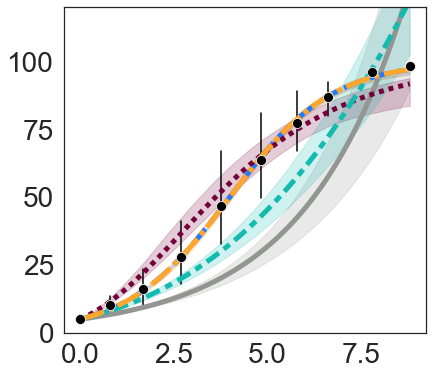

In [9]:
outDir = os.path.join(modelDir,cellLine)
currData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="lowDensity")]
# Load models and simulate
tmpList = []
for modelName in tqdm(modelList):
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir, modelName))
    # Simulate
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    currPredictionDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                             treatmentScheduleList=utils.ExtractTreatmentFromDf(currData),
                                                             show_progress = False, n_time_steps=100,
                                                             alpha=ci_significanceLevel,
                                                             solver_kws=solver_kws, optimiser_kws=optimiser_kws)
    currPredictionDf.rename(columns={"Estimate_MLE":"TumourSize"}, inplace=True)
    currPredictionDf['Model'] = modelName
    currPredictionDf['CellLine'] = cellLine
    tmpList.append(currPredictionDf.copy())
modelFitsDf = pd.concat(tmpList)

# Plot
fig, ax = plt.subplots(1,1,figsize=(6.5,6))
sns.lineplot(x="Time",y="TumourSize", hue="Model", style="Model",
             lw=5,palette=modelPalette,
             legend=False,
             data=modelFitsDf, ax=ax)
for modelName in modelList:
    currPredictionDf = modelFitsDf[modelFitsDf.Model==modelName]
    plt.fill_between(currPredictionDf.Time, currPredictionDf['CI_Lower_Bound'], 
                     currPredictionDf['CI_Upper_Bound'], color=modelPalette[modelName], alpha=0.2)

sns.lineplot(x="Time",y="Confluence",style="CellLine",err_style='bars', #units="ReplicateId", estimator=None,
         markers="o", lw=0, markersize=10, color="black",
         legend=False,
        data=currData,ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,120)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/fits_growthModel_%s.pdf"%cellLine)

#### Plot inferred density-dependence relationship

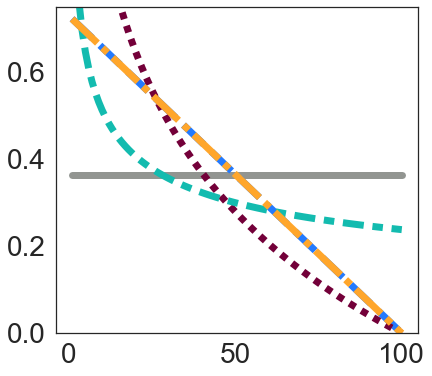

In [10]:
xVec = np.linspace(1,100,100)
# 1. Compute the per-capita growth rate under each model (using the estimated parameters)
outDir = os.path.join(modelDir,cellLine)
tmpDfList = []
for modelName in modelList:
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir, modelName))
    perCapitaGrowthRateList = [myModel.ModelEqns(None,[x,0])[0]/x for x in xVec]
    tmpDf = pd.DataFrame({"Model":modelName, "Density":xVec, 
                          "PerCapitaGrowthRate":perCapitaGrowthRateList})
    tmpDfList.append(tmpDf)
growthRateDf = pd.concat(tmpDfList)

# 2. Plot
fig, ax = plt.subplots(1,1,figsize=(6.5,6))
sns.lineplot(x="Density",y="PerCapitaGrowthRate", hue="Model", style="Model",
                 lw=7,palette=modelPalette,
                 legend=False,
                 data=growthRateDf, ax=ax)
ax.set_ylim(0,0.75)
ax.tick_params(labelsize=28)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/densityDependence_%s.pdf"%cellLine)

#### Quantify goodness-of-fit using AIC

100%|██████████| 5/5 [00:00<00:00, 657.21it/s]


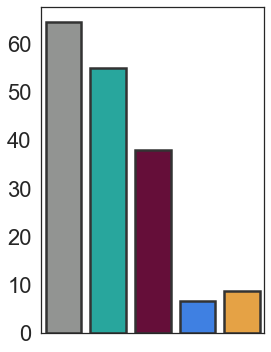

In [11]:
measure = "AIC"
outDir = os.path.join(modelDir,cellLine)
tmpList = []
for modelName in tqdm(modelList):
    fitObj,_ = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))
    tmpList.append({"Model":modelName, "FitId":fitObj.fitId,
                    "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
comparisonDf_gof = pd.DataFrame(tmpList)

# Plot
fig, ax = plt.subplots(1,1,figsize=(4,6))
comparisonDf_gof.sort_values(by=measure,inplace=True)
sns.barplot(x="Model",y=measure,
            edgecolor=".2",linewidth=2.5,
            palette=modelPalette,
            order=["Exponential", "vonBertalanffy", "Gompertz", "Logistic", "GeneralisedLogistic"],
            data=comparisonDf_gof, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
plt.savefig("./figures/%s_fit_%s.pdf"%(measure,cellLine))

In [12]:
comparisonDf_gof.loc[comparisonDf_gof.Model=="Logistic",'AIC'].values - comparisonDf_gof.loc[comparisonDf_gof.Model=="GeneralisedLogistic",'AIC'].values



array([-1.99975938])

### b) Test model by benchmarking its ability to predict growth from higher initial seeding density

#### Generate predictions

In [13]:
# Run predictions
tmpList = []
outDir = os.path.join(modelDir,cellLine)
testingDataDf = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]
testingDataDf = testingDataDf.groupby(by="Time").mean()
testingDataDf.reset_index(inplace=True)

# Load models and simulate
for modelName in tqdm(modelList):
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))

    # Simulate
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    currPredictionDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(testingDataDf),
                                                     initialConditionsList={"N0":testingDataDf.Confluence.iloc[0]},
                                                     show_progress=False, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws)

    currPredictionDf.rename(columns={"Estimate_MLE":"TumourSize"}, inplace=True)
    currPredictionDf['Model'] = modelName
    currPredictionDf['CellLine'] = cellLine
    tmpList.append(currPredictionDf.copy())
modelPredictionDf = pd.concat(tmpList)

100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


#### Plot predictions

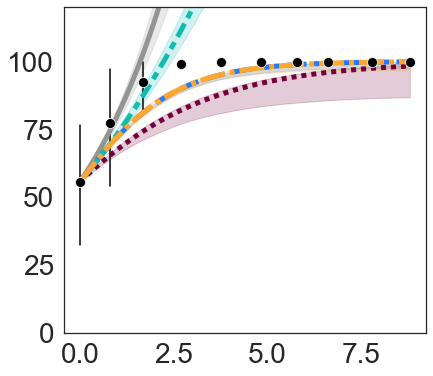

In [14]:
# Plot Predictions
outDir = os.path.join(modelDir,cellLine)
testingData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]

# Plot
fig, ax = plt.subplots(1,1,figsize=(6.5,6))
sns.lineplot(x="Time",y="TumourSize", hue="Model", style="Model",
         lw=5,palette=modelPalette,
         legend=False,
         data=modelPredictionDf[modelPredictionDf.CellLine==cellLine], ax=ax)
for modelName in modelList:
    currPredictionDf = modelPredictionDf[(modelPredictionDf.CellLine==cellLine) & 
                                         (modelPredictionDf.Model==modelName)]
    plt.fill_between(currPredictionDf.Time, currPredictionDf['CI_Lower_Bound'], 
                     currPredictionDf['CI_Upper_Bound'], color=modelPalette[modelName], alpha=0.2)

sns.lineplot(x="Time",y="Confluence",style="CellLine",err_style='bars', #units="ReplicateId", estimator=None,
         markers="o", lw=0, markersize=10, color="black",
         legend=False,
        data=testingData,ax=ax)
ax.set_ylim(0,120)
ax.tick_params(labelsize=28)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/predictions_growthModel_%s.pdf"%cellLine)

#### Quantify goodness-of-fit of the predictions

In [15]:
# Run predictions
tmpList = []
outDir = os.path.join(modelDir,cellLine)
testingDataDf = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]
testingDataDf = testingDataDf.groupby(by="Time").mean()
testingDataDf.reset_index(inplace=True)

# Load models and simulate
for modelName in tqdm(modelList):
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))

    # Simulate
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    currBenchmarkResultsDf = benchmark_prediction_accuracy(fitObj=fitObj, 
                                                           bootstrapResultsDf=bootstrapResultsDf, 
                                                           dataDf=testingDataDf,
                                                           initialConditionsList={"N0":testingDataDf.Confluence.iloc[0]},
                                                           show_progress=False, solver_kws=solver_kws)
    currBenchmarkResultsDf['Model'] = modelName
    currBenchmarkResultsDf['CellLine'] = cellLine
    tmpList.append(currBenchmarkResultsDf.copy())
modelPredictionDf_comp = pd.concat(tmpList)

100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


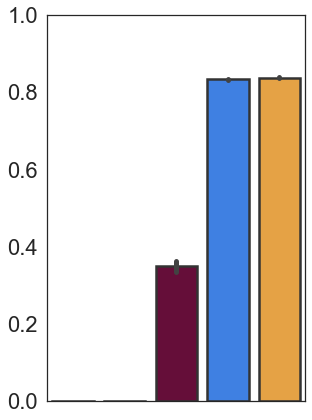

In [16]:
measure = "rSquared"
fig, ax = plt.subplots(1,1,figsize=(4.5,6))
sns.barplot(x="Model", y=measure,
            edgecolor=".2", linewidth=2.5, errwidth=5,
            palette=modelPalette,
            order=["Exponential", "vonBertalanffy", "Gompertz", "Logistic", "GeneralisedLogistic"],
            data=modelPredictionDf_comp[modelPredictionDf_comp.CellLine==cellLine], ax=ax)
ax.set_ylim(0,1)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
plt.tight_layout()
plt.savefig("./figures/predictions_growth_hd_%s.pdf"%(cellLine))

### c) & d) Summary plot and table of parameter estimates for OVCAR3

In [18]:
# Assemble parameter estimates and confidence intervals
tmpList = []
for cellLine, modelName in product(["OVCAR3", "OVCAR4"], modelList):
    outDir = os.path.join(modelDir,cellLine)
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    tmpDf = compute_confidenceInterval_parameters(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf)
    tmpDf['Model'] = modelName
    tmpDf['CellLine'] = cellLine
    tmpList.append(tmpDf)
paramsDf = pd.concat(tmpList)

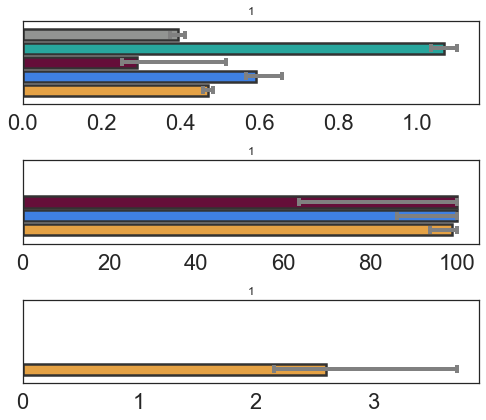

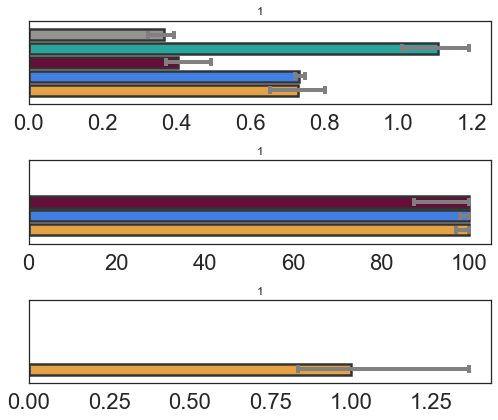

In [19]:
plottingOrder = {"GeneralisedLogistic":0, "Logistic":1, "Gompertz":2, "vonBertalanffy":3, "Exponential":4}
for cellLine in ["OVCAR3", "OVCAR4"]:
    fig, axList = plt.subplots(3,1,figsize=(7,6))
    for i,par in enumerate(['r','K','v']):
        ax = axList[i]
        currDataDf = paramsDf[(paramsDf.CellLine==cellLine) & ((paramsDf.Parameter==par))]
        currDataDf = currDataDf.sort_values(by=['Model'], key=lambda x: x.map(plottingOrder))
        sns.barplot(x="Estimate_MLE",y="Model",
                    edgecolor=".2",linewidth=2.5,
                    palette=modelPalette,
                    data=currDataDf,ax=axList[i])
        # Extract and plot error bars
        ax.errorbar(x=currDataDf["Estimate_MLE"], 
                    y=np.arange(currDataDf.shape[0]),
                    xerr=np.array([currDataDf['Estimate_MLE']-currDataDf['Lower_Bound'],
                                   currDataDf['Upper_Bound']-currDataDf['Estimate_MLE']]), 
                    fmt='none', c='grey', capsize=4, elinewidth=4, capthick=4)
        ax.set_ylim(-1,len(modelList))
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_yticks([])
        ax.set_title("1")
    plt.tight_layout()
    plt.savefig("./figures/params_growthModel_%s.pdf"%cellLine)

In [22]:
paramsDf[paramsDf.CellLine=="OVCAR3"]

,Parameter,Estimate_MLE,Lower_Bound,Upper_Bound,Model,CellLine
0,r,0.393974,0.374693,0.411449,Exponential,OVCAR3
0,r,0.592279,0.565108,0.656552,Logistic,OVCAR3
1,K,100.000000,86.029514,100.000000,Logistic,OVCAR3
0,r,0.291365,0.252957,0.516162,Gompertz,OVCAR3
1,K,100.000000,63.578473,100.000000,Gompertz,OVCAR3
0,r,1.068020,1.034863,1.101996,vonBertalanffy,OVCAR3
0,r,0.468891,0.456555,0.481810,GeneralisedLogistic,OVCAR3
1,K,98.755814,93.768203,100.000000,GeneralisedLogistic,OVCAR3
2,v,2.603333,2.157254,3.725653,GeneralisedLogistic,OVCAR3


In [23]:
paramsDf[paramsDf.CellLine=="OVCAR4"]

,Parameter,Estimate_MLE,Lower_Bound,Upper_Bound,Model,CellLine
0,r,0.365024,0.324241,0.394342,Exponential,OVCAR4
0,r,0.730627,0.720084,0.748529,Logistic,OVCAR4
1,K,100.000000,97.806031,100.000000,Logistic,OVCAR4
0,r,0.403343,0.370502,0.492900,Gompertz,OVCAR4
1,K,100.000000,87.410524,100.000000,Gompertz,OVCAR4
0,r,1.106461,1.009066,1.192635,vonBertalanffy,OVCAR4
0,r,0.730168,0.653235,0.802894,GeneralisedLogistic,OVCAR4
1,K,100.000000,96.859426,100.000000,GeneralisedLogistic,OVCAR4
2,v,1.001323,0.835176,1.367853,GeneralisedLogistic,OVCAR4


## Supplementary Figure 2: Development of the treatment model

In [5]:
# Data and solver configurations
cellLine = "OVCAR3"
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':2}
# Due to the random perturbations during bootstrapping the ODE solver can fail whilst fitting 
# to the synthetic data. To fix this, use more stringent solver arguments
solver_kws_bootstrapping = solver_kws.copy()
solver_kws_bootstrapping['max_step'] = 0.5

# Load growth model parameters
growthModel = "GeneralisedLogistic"
fitObj,_ = LoadFit(growthModel,fitDir=os.path.join("./fits/growthModel/%s"%cellLine,growthModel))
params_growth = fitObj.params
params_growth['r'].set(vary=False)
params_growth['K'].set(vary=False)
params_growth['v'].set(vary=False)
params_growth['N0'].set(vary=False)
growthModelBootstrapsDf = pd.read_csv(os.path.join("./fits/growthModel/%s"%cellLine, growthModel, "bootstraps.csv"), index_col=0)

# Parameters for the multi-step model
nStepsList = np.arange(1,5) # Which parameter values for n_steps to examine
treatmentModelsList = ["singleStep", "multiStep_equalParams", 
                       "multiStep_varying_r", "multiStep_varying_r_decreasing", "multiStep_varying_alpha", 
                       "multiStep_2phase", "singleStep_extraDivs"]
multiStepModelList = [x for x in treatmentModelsList if x.split("_")[0]=="multiStep"]
params = params_growth.copy()
params.add('alpha', value=0.75, min=0, max=1, vary=True)
params.add('beta', value=0.1, min=0, max=5e-1, vary=True)
params.add('gamma', value=0.1, min=0, max=4, vary=True)
params.add('d_A', value=5e-2, min=0, max=4, vary=True)
params.add('n_steps', value=2, min=1, max=5, vary=False)
# Assume that all accumulating damage does not alter the proliferation rate (r) or sensitivity to drug (alpha)
for x in range(params['n_steps'].max):
    params.add('r%d'%x, value=params['r'].value, min=params['r'].min, max=params['r'].max, vary=False)
for x in range(params['n_steps'].max):
    params.add('alpha%d'%x, value=params['alpha'].value, min=params['alpha'].min, max=params['alpha'].max, vary=False)
# Assume that initially all cells are in the P compartment
for x in range(params['n_steps'].max):
    params.add('P%d0'%x, value=0, vary=False)
params.add('A0', value=0, vary=False)

# Environment
dataDir = "./data/"
modelDir = "./fits/"

In [6]:
# Load the treatment data for model development and testing
dataDf_all = pd.read_csv("./data/intermittentTreatmentDf_cleaned.csv", index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DMax==100) & (dataDf_all.CellLine==cellLine)] # Only select 100uM experiment here. Will use 50uM when developing the dose-resoponse model

# For model development, use the data for CT treatment
trainingDataDf_all = dataDf_all[dataDf_all.Delay==100]
trainingDataDf_avg = trainingDataDf_all.groupby(by="Time").mean().reset_index()

# For model testing, use the data from the 7d-on experiment
testingDataDf_all = dataDf_all[dataDf_all.Delay==7]
testingDataDf_avg = testingDataDf_all.groupby(by="Time").mean().reset_index()

In [34]:
# Function to retrieve the model class name (type) associated with each model/submodel we fitted
def Lookup_modelType(modelName):
    if modelName=="singleStep": modelType = "CycleArrestModel_singleStep"
    elif modelName=="singleStep_extraDivs": modelType = "CycleArrestModel_singleStep_extraDivs"        
    elif modelName=="multiStep_2phase": modelType = "CycleArrestModel_multiStep_2phase"
    else: modelType = "CycleArrestModel_multiStep"
    return modelType

### a) Plot fits of Model 2 for different numbers of proliferating compartments (#Hits)

In [128]:
modelName = "multiStep_equalParams"

In [129]:
# Load models and simulate
tmpDfList = []
for n_steps in nStepsList:
    currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName, "n_steps_%d"%(n_steps))
    fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)
    bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
    modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                         treatmentScheduleList=utils.ExtractTreatmentFromDf(trainingDataDf_avg),
                                                         model_kws={"n_steps":n_steps},
                                                         show_progress=True, n_time_steps=100,
                                                         alpha=ci_significanceLevel,
                                                         solver_kws=solver_kws)
    modelFitsDf['modelName'] = modelName
    modelFitsDf['n_steps'] = n_steps
    tmpDfList.append(modelFitsDf)
modelFitsDf = pd.concat(tmpDfList)

100%|██████████| 25/25 [00:00<00:00, 38.00it/s]


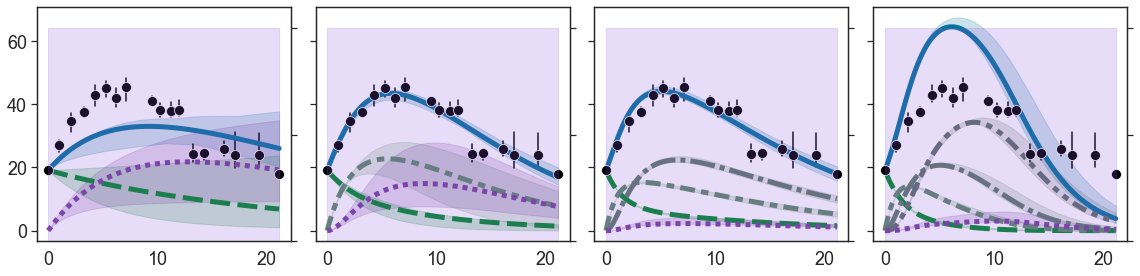

In [23]:
fig, axList = plt.subplots(1,len(nStepsList),sharex=True,sharey=True,figsize=(4*len(nStepsList),4))
for i, n_steps in enumerate(nStepsList):
    currModelFitsDf = modelFitsDf[(modelFitsDf.modelName==modelName) & (modelFitsDf.n_steps==n_steps)]
    # 1. Plot the model predictions and associated confidence intervals
    ax = axList.flatten()[i]
    sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=5, palette=multiStepPalette,
                 style_order=["TumourSize","P0","A"]+["P%d"%x for x in range(1,n_steps)],
                 legend=False,
                 data=currModelFitsDf, ax=ax)
    for var in multiStepPalette.keys():
        currDataDf = currModelFitsDf[currModelFitsDf.Variable==var]
        ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                         currDataDf['CI_Upper_Bound'], color=multiStepPalette[var], alpha=0.2)
    # 2. Plot the data
    sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=trainingDataDf_all, ax=ax)
    # 3. Plot the drug concentration
    tmpDf = trainingDataDf_avg.copy()
    tmpDf.Confluence = np.nan
    PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
    ax.tick_params(labelsize=18)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig("./figures/fits_different_n_steps_%s.pdf"%(cellLine))

In [134]:
# Load models and simulate
tmpDfList = []
for n_steps in nStepsList:
    currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName, "n_steps_%d"%(n_steps))
    fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)
    print(n_steps,fitObj.rSq)

1 0.18837388553462742
2 0.9090363019342347
3 0.8955300487128767
4 -1.1158642812907251


### b) Comparison of fit and predictive power of different multistep models

#### Model 2: Fit for different assumptions about which parameters are (or are not) allowed to change as damage accumulates

##### Varying growth rates as damage is accumulated

In [7]:
# Setup environment
modelType = Lookup_modelType("multiStep_varying_r")
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_varying_r")

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelType, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Allow r to change once the cell has been hit
        currParams.add(params['r'])
        currParams.add(params['alpha'])
        currParams['r0'].set(expr='r', vary=False) # growth rate of proliferating population is fixed as it was determined from the control experiments
        currParams['alpha0'].set(expr='alpha', vary=False) # assume alpha doesn't change as damage accumulates. Need this extra line as for loop in next line starts at n_steps=1.
        for x in range(1, n_steps):
            currParams['r%d'%x].set(vary=True) # No constraints on r
            currParams['alpha%d'%x].set(expr='alpha', vary=False)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelType
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3992e+03                                    5.77e+03    
       1              2         8.2415e+02      5.75e+02       1.42e-01       3.73e+03    
       2              3         7.2460e+02      9.96e+01       2.14e-02       1.55e+03    
       3              5         6.9631e+02      2.83e+01       8.11e-02       2.50e+04    
       4              6         6.1697e+02      7.93e+01       3.28e-02       1.01e+03    
       5              8         6.1207e+02      4.90e+00       9.09e-03       2.38e+02    
       6              9         6.0580e+02      6.26e+00       1.28e-02       9.38e+02    
       7             11         6.0292e+02      2.88e+00       7.78e-03       2.64e+01    
       8             12         5.9764e+02      5.28e+00       1.22e-03       9.56e+00    
       9             13         5.9437e+02      3.27e+00       1.27e-02       1.11e+03    

      32             41         6.3456e+01      2.30e-07       2.26e-04       4.48e-03    
`ftol` termination condition is satisfied.
Function evaluations 41, initial cost 2.7183e+04, final cost 6.3456e+01, first-order optimality 4.48e-03.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9084e+04                                    9.21e+03    
       1              2         1.5899e+04      1.32e+04       2.88e+00       3.98e+04    
       2              3         1.0047e+03      1.49e+04       6.70e-01       1.16e+04    
       3              4         2.2131e+02      7.83e+02       3.00e-01       6.91e+03    
       4              5         7.9068e+01      1.42e+02       1.96e-01       1.47e+03    
       5              6         6.5487e+01      1.36e+01       8.45e-02       3.13e+02    
       6              7         6.3657e+01      1.83e+00       2.00e-01       3.31e+02    
       7              8         

##### Varying kill rates as damage is accumulated

In [10]:
# Setup environment
modelType = Lookup_modelType("multiStep_varying_alpha")
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_varying_alpha")

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelType, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Allow r to change once the cell has been hit
        currParams.add(params['r'])
        currParams['r0'].set(expr='r', vary=False) # growth rate of proliferating population is fixed as it was determined from the control experiments
        currParams['alpha0'].set(vary=True) # Need this extra line as for loop in next line starts at n_steps=1.
        for x in range(1, n_steps):
            currParams['r%d'%x].set(expr='r', vary=False)
            currParams['alpha%d'%x].set(vary=True)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelType
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3992e+03                                    5.77e+03    
       1              2         8.2415e+02      5.75e+02       1.42e-01       3.73e+03    
       2              3         7.2460e+02      9.96e+01       2.14e-02       1.55e+03    
       3              5         6.9631e+02      2.83e+01       8.11e-02       2.50e+04    
       4              6         6.1697e+02      7.93e+01       3.28e-02       1.01e+03    
       5              8         6.1207e+02      4.90e+00       9.09e-03       2.38e+02    
       6              9         6.0580e+02      6.26e+00       1.28e-02       9.38e+02    
       7             11         6.0292e+02      2.88e+00       7.78e-03       2.64e+01    
       8             12         5.9764e+02      5.28e+00       1.22e-03       9.56e+00    
       9             13         5.9437e+02      3.27e+00       1.27e-02       1.11e+03    

      14             19         7.6250e+01      1.80e-08       1.33e-04       1.40e-03    
      15             20         7.6250e+01      3.68e-08       3.36e-05       5.59e-04    
`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 2.7183e+04, final cost 7.6250e+01, first-order optimality 5.59e-04.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9084e+04                                    9.21e+03    
       1              2         2.3529e+04      5.55e+03       2.92e+00       4.21e+03    
       2              3         2.6654e+03      2.09e+04       7.97e-01       5.63e+02    
       3              4         1.9415e+03      7.24e+02       1.49e-01       1.74e+02    
       4              5         1.6713e+03      2.70e+02       7.86e-02       5.27e+01    
       5              6         1.5763e+03      9.50e+01       2.98e-02       1.42e+01    
       6              7         

#### Model 3: Fit model which assumes that cells eventually become apoptotic independent of proliferation

In [11]:
# Setup environment
modelType = Lookup_modelType("multiStep_2phase")
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType)

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelType, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Assume r and alpha are the same across all populations
        currParams.add(params['r'])        
        currParams.add(params['alpha'])
#         currParams['beta'].set(value=0, vary=False)
        for x in range(n_steps):
            currParams['r%d'%x].set(expr='r', vary=False)
            currParams['alpha%d'%x].set(expr='alpha', vary=False)
        currParams['r%d'%(x+1)].set(expr='r', vary=False)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelType
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8711e+04                                    5.34e+04    
       1              2         4.1966e+03      2.45e+04       1.80e+00       1.12e+04    
       2              4         1.9820e+03      2.21e+03       7.83e-02       1.36e+04    
       3              5         7.3903e+02      1.24e+03       2.04e-01       2.41e+04    
       4              6         2.5407e+02      4.85e+02       3.89e-01       3.76e+03    
       5              8         1.8274e+02      7.13e+01       1.43e-01       2.40e+02    
       6              9         1.2364e+02      5.91e+01       1.97e-01       3.83e+03    
       7             11         1.0169e+02      2.20e+01       7.04e-02       2.56e+02    
       8             12         8.9382e+01      1.23e+01       6.84e-02       4.35e+01    
       9             14         8.7081e+01      2.30e+00       2.84e-02       1.73e+02    

       8              9         1.7667e+02      8.84e-01       1.02e-02       9.32e-01    
       9             10         1.7659e+02      7.37e-02       4.29e-04       6.94e-01    
      10             11         1.7659e+02      3.08e-04       1.42e-06       1.47e-02    
      11             12         1.7659e+02      1.57e-06       9.93e-08       8.71e-03    
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 2.9648e+04, final cost 1.7659e+02, first-order optimality 8.71e-03.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9859e+04                                    8.14e+03    
       1              2         2.7553e+04      2.31e+03       3.01e+00       2.52e+03    
       2              3         6.8839e+03      2.07e+04       1.47e+00       2.66e+03    
       3              4         4.5041e+03      2.38e+03       6.83e-01       7.96e+02    
       4              5         

#### Identify best fitting #Hits (n) value for each model and perform uncertainty estimation for this value

In [8]:
modelsToBootstrapList = ["multiStep_varying_r", "multiStep_varying_alpha", "multiStep_2phase"]

In [9]:
# Assemble goodness-of-fit quantifications to identify best fitting model for each model
tmpList_total = []
for modelName in modelsToBootstrapList:
    tmpList_subModel = []
    for n_steps in nStepsList:
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName, "n_steps_%d"%(n_steps))
        fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)    
        tmpList_subModel.append({"ModelName":modelName.split("multiStep_")[-1], "n_steps":n_steps,
                        "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
    tmpDf = pd.DataFrame(tmpList_subModel)
    tmpList_total.append(tmpDf.loc[tmpDf.AIC.idxmin()])
modelComparisonDf = pd.DataFrame(tmpList_total)

In [10]:
# Turn off verboseness for bootstrapping
optimiser_kws_bootstrapping = optimiser_kws.copy()
optimiser_kws_bootstrapping['verbose'] = 0

if runFitting:
    # Use multi-threading to speed up computation
    pool = mp.Pool(processes=nProcesses)
    def bootstrapJob(job):
        fitObj, n_steps, outName = job
        return perform_bootstrap(fitObj=fitObj,
                          prior_experiment_df=growthModelBootstrapsDf,
                          model_kws={"n_steps":n_steps},
                          shuffle_params=len(outName.split("varying_r"))==1, # Turn this off as there are multiple optima in this case and we don't want to sample from the worse optimum                                 
                          n_bootstraps=n_bootstraps, show_progress=True,
                          solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws_bootstrapping, 
                          outName=outName)    
    jobList = []
    for _, (modelName, n_steps) in modelComparisonDf[['ModelName', 'n_steps']].iterrows():
        modelType = Lookup_modelType(modelName)
        outDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName, "n_steps_%d"%(n_steps))
        fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=outDir)
        jobList.append([fitObj,n_steps,os.path.join(outDir, "bootstraps.csv")])
#     [bootstrapJob(x) for x in jobList]
    list(tqdm(pool.imap(bootstrapJob, jobList), total=len(jobList)));

100%|██████████| 3/3 [06:45<00:00, 135.30s/it]


#### Plot best model fit for each model (i.e. fit with n value which produced best fit for each)

In [11]:
modelsToPlotList = ["multiStep_equalParams", "multiStep_varying_r", "multiStep_varying_alpha", 
                       "multiStep_2phase", "singleStep_extraDivs"]

In [12]:
# Assemble goodness-of-fit quantifications to identify best fitting model for each model
tmpList_total = []
for modelName in modelsToPlotList:
    # For the single compartment model (Model 3) there is only a single fit, so use that. For the
    # multi-compartment models choose the best one among the different n_step values.
    if modelName=="singleStep_extraDivs":
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
        fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)    
        tmpList_total.append(pd.Series({"ModelName":modelName, "n_steps":np.nan,
                        "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic}))
    else:
        tmpList_subModel = []
        for n_steps in nStepsList:
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName, "n_steps_%d"%(n_steps))
            fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)    
            tmpList_subModel.append({"ModelName":modelName.split("multiStep_")[-1], "n_steps":n_steps,
                            "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
        tmpDf = pd.DataFrame(tmpList_subModel)
        tmpList_total.append(tmpDf.loc[tmpDf.AIC.idxmin()])
modelComparisonDf = pd.DataFrame(tmpList_total)
modelComparisonDf.to_csv("./fits/treatmentModel/modelComparisonDf_100uM_OVCAR3.csv")

In [13]:
# Load models and simulate
tmpDfList = []
for _, (modelName, n_steps) in modelComparisonDf[['ModelName', 'n_steps']].iterrows():
    # Due to the different format of the 2-compartment and multi-compartment models they need
    # to be loaded in slightly diffrerent ways. Deal with that here.
    modelType = Lookup_modelType(modelName)
    if modelName=="singleStep_extraDivs":
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
        model_kws = {}
        initialConditionsList = {"P0":trainingDataDf_avg.Confluence.iloc[0], "A0":0}
    else:
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName, "n_steps_%d"%(n_steps))
        model_kws = {"n_steps":int(n_steps)}
        initialConditionsList = {"P00":trainingDataDf_avg.Confluence.iloc[0], "P10":0, "A0":0}
    # Carry out the model simulations to obtain the confidence intervals.
    fitObj,_ = LoadFit(modelType,fitDir=currOutDir)  
    bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
    modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, 
                                                        bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                        treatmentScheduleList=utils.ExtractTreatmentFromDf(trainingDataDf_avg),
                                                        model_kws=model_kws, 
                                                        initialConditionsList=initialConditionsList,
                                                        show_progress=True, n_time_steps=100,
                                                        alpha=ci_significanceLevel,
                                                        solver_kws=solver_kws_bootstrapping)
    modelFitsDf['ModelName'] = modelName
    tmpDfList.append(modelFitsDf)
fitComparisonDf = pd.concat(tmpDfList)

100%|██████████| 25/25 [00:00<00:00, 51.93it/s]


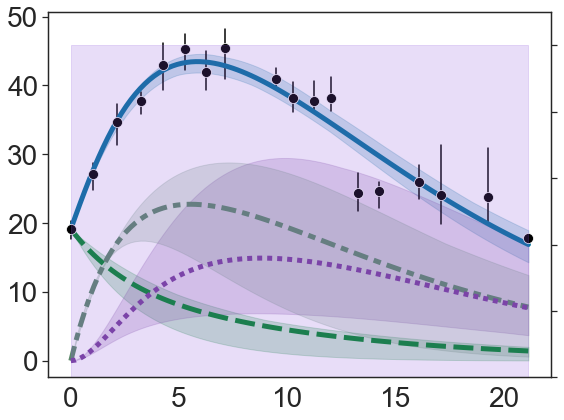

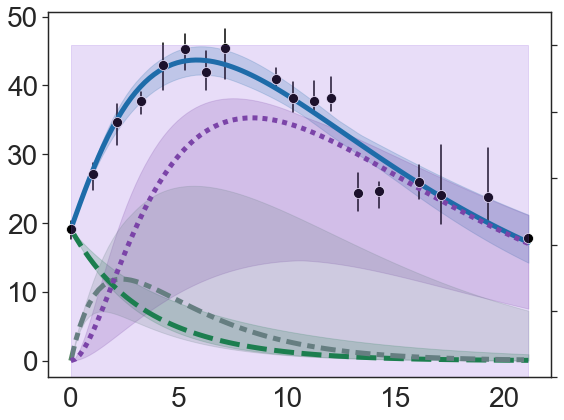

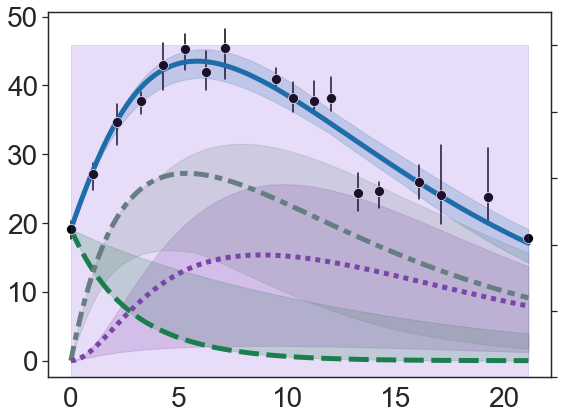

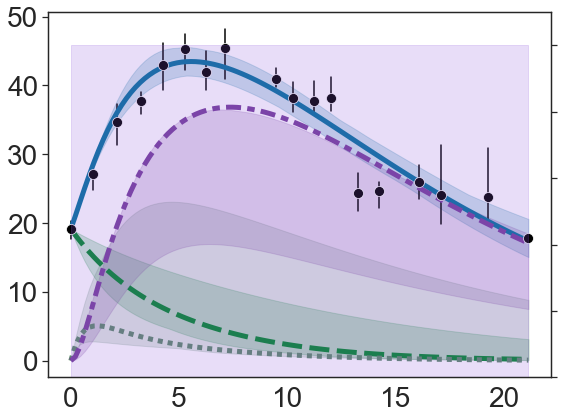

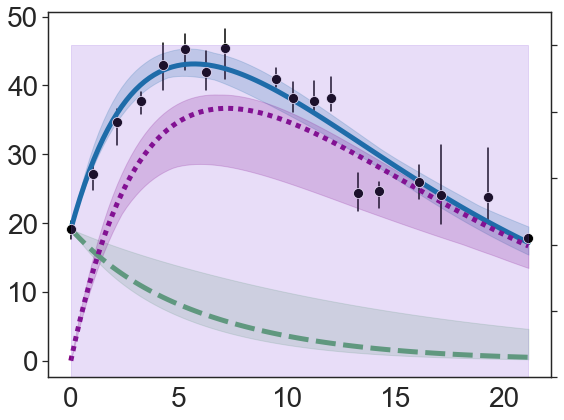

In [14]:
for _, (modelName, n_steps) in modelComparisonDf[['ModelName', 'n_steps']].iterrows():
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    # 1. Plot the model predictions and associated confidence intervals
    currModelPredictionsDf = fitComparisonDf[(fitComparisonDf.ModelName==modelName)]
    if modelName=="2phase": variableList = ["TumourSize","P0","P1","A"]
    elif modelName=="singleStep_extraDivs": variableList = ["TumourSize","P","A"]
    else: variableList = ["TumourSize","P0","A"]+["P%d"%x for x in range(1,int(n_steps))]
    currPalette = multiStepPalette if modelName!="singleStep_extraDivs" else cycleArrestModelPalette        
    sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=5, palette=currPalette,
                 style_order=variableList,
                 legend=False,
                 data=currModelPredictionsDf, ax=ax)
    for var in variableList:
        currDataDf = currModelPredictionsDf[currModelPredictionsDf.Variable==var]
        ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                         currDataDf['CI_Upper_Bound'], color=currPalette[var], alpha=0.2)
    # 2. Plot the data
    sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=trainingDataDf_all, ax=ax)
    # 3. Plot the drug concentration
    tmpDf = trainingDataDf_avg.copy()
    tmpDf.Confluence = np.nan
    PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
    ax.tick_params(labelsize=28)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig("./figures/fitComparison_CT_100uM_%s_%s.pdf"%(cellLine,modelName))

In [15]:
modelComparisonDf

,ModelName,n_steps,r2,AIC,BIC
1,equalParams,2.0,0.909036,41.989086,44.660201
1,varying_r,2.0,0.912273,43.336940,46.898427
1,varying_alpha,2.0,0.910506,43.695806,47.257293
0,2phase,1.0,0.905588,44.658758,48.220245
Unnamed 0,singleStep_extraDivs,NaN,0.902713,43.198683,45.869799


#### Plot predictions for intermittent data for each model (i.e. fit with n value which produced best fit for each)

In [16]:
modelComparisonDf = pd.read_csv("./fits/treatmentModel/modelComparisonDf_100uM_OVCAR3.csv", index_col=0)

In [17]:
# Load models and simulate
tmpDfList = []
for _, (modelName, n_steps) in modelComparisonDf[['ModelName', 'n_steps']].iterrows():
    for delay in [1,2,4,7]:
        currTestingDataDf_avg = dataDf_all[dataDf_all.Delay==delay].groupby(by="Time").mean().reset_index()
        # Due to the different format of the 2-compartment and multi-compartment models they need
        # to be loaded in slightly diffrerent ways. Deal with that here.
        modelType = Lookup_modelType(modelName)
        if modelName=="singleStep_extraDivs":
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
            model_kws = {}
            initialConditionsList = {"P0":currTestingDataDf_avg.Confluence.iloc[0], "A0":0}
        else:
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName, "n_steps_%d"%(n_steps))
            model_kws = {"n_steps":int(n_steps)}
            initialConditionsList = {"P00":currTestingDataDf_avg.Confluence.iloc[0], "P10":0, "A0":0}
        # Carry out the model simulations to obtain the confidence intervals.
        fitObj,_ = LoadFit(modelType,fitDir=currOutDir)  
        bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
        modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, 
                                                            bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                            treatmentScheduleList=utils.ExtractTreatmentFromDf(currTestingDataDf_avg),
                                                            model_kws=model_kws, 
                                                            initialConditionsList=initialConditionsList,
                                                            show_progress=True, n_time_steps=100,
                                                            alpha=ci_significanceLevel,
                                                            solver_kws=solver_kws_bootstrapping)
        modelFitsDf['ModelName'] = modelName
        modelFitsDf['Delay'] = delay
        tmpDfList.append(modelFitsDf)
predictionComparisonDf = pd.concat(tmpDfList)

100%|██████████| 25/25 [00:00<00:00, 50.24it/s]


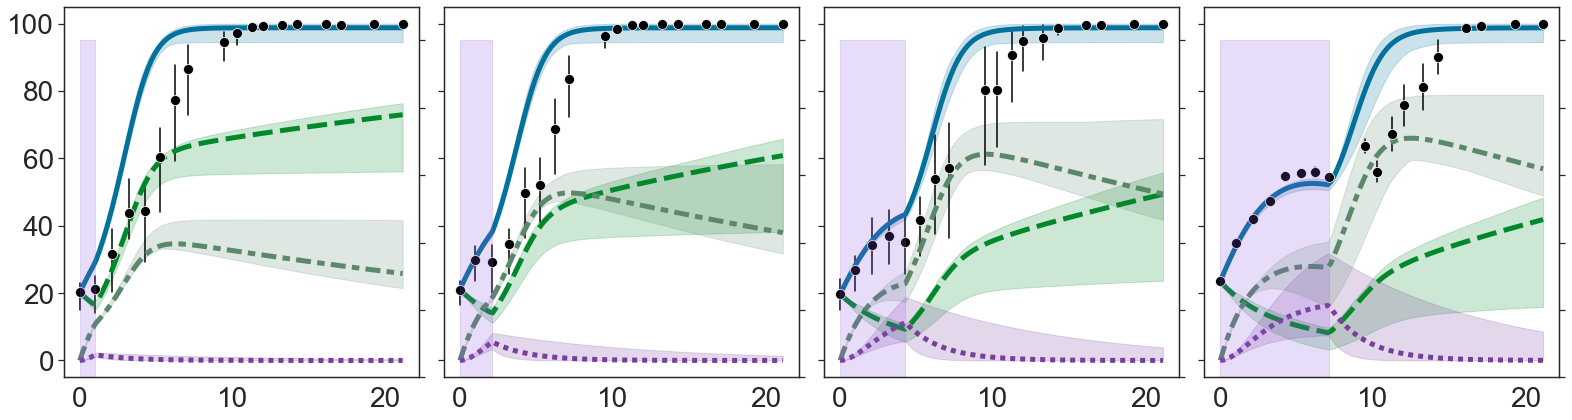

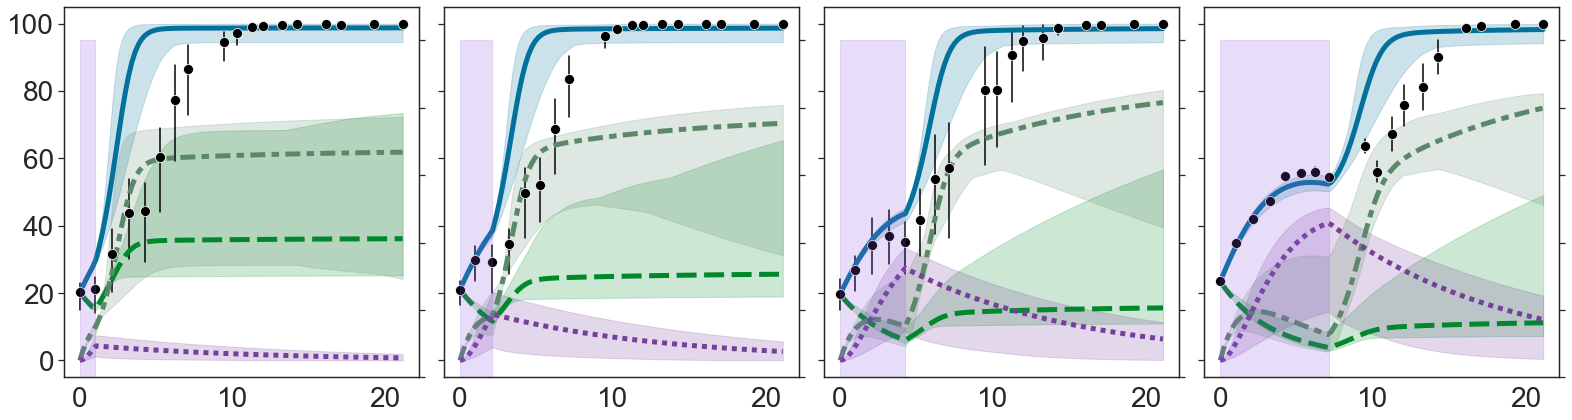

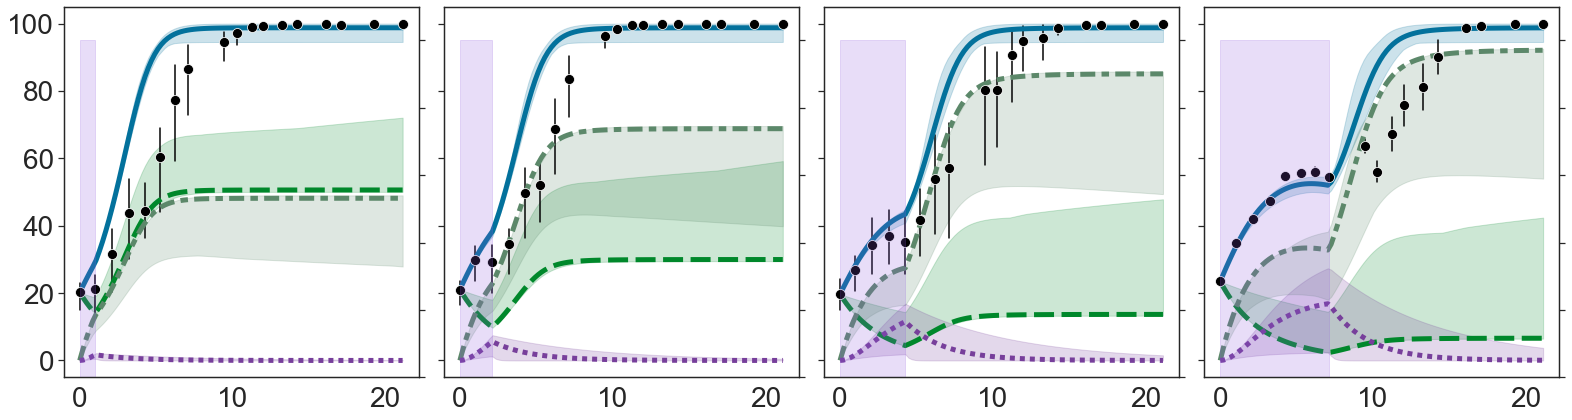

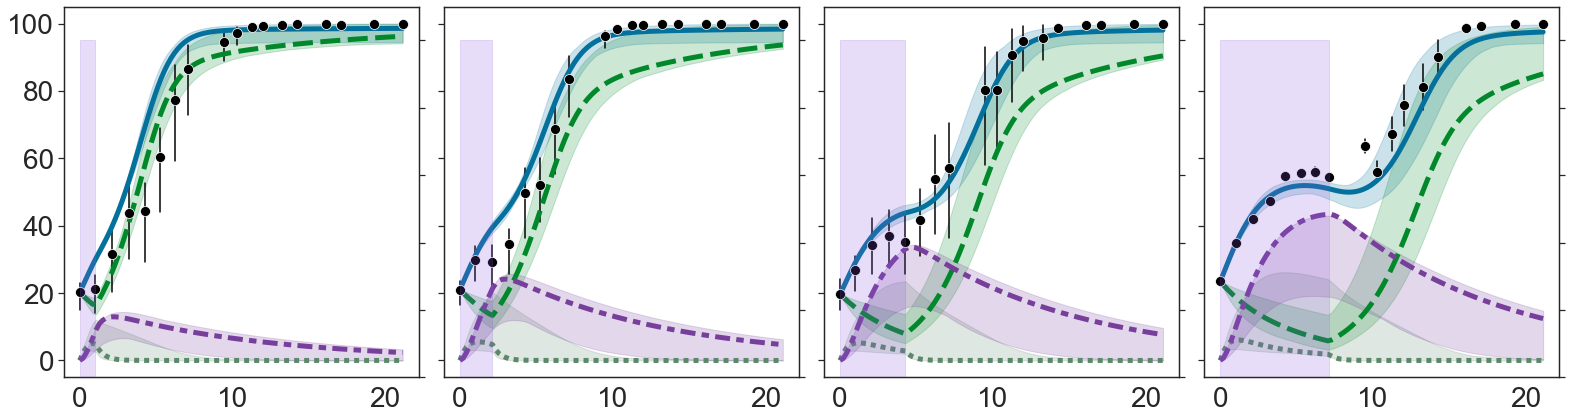

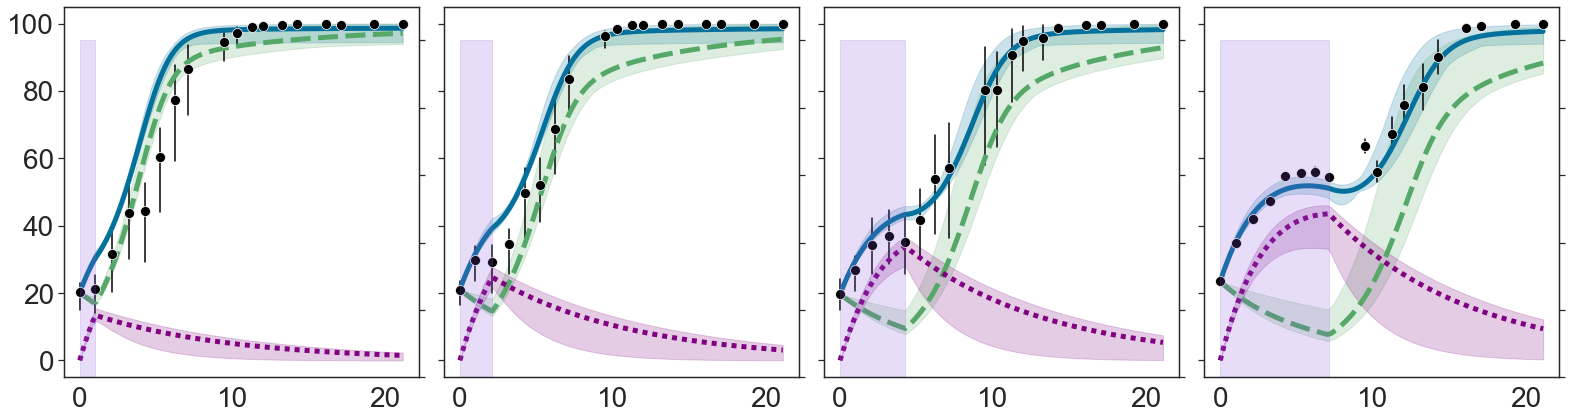

In [18]:
delayList = predictionComparisonDf.Delay.unique()
for _, (modelName, n_steps) in modelComparisonDf[['ModelName', 'n_steps']].iterrows():
    fig, axList = plt.subplots(1,len(delayList),sharex=True,sharey=True,figsize=(22,6))
    for i,delay in enumerate(delayList):
        ax = axList[i]
        # 1. Plot the model predictions and associated confidence intervals
        currModelPredictionsDf = predictionComparisonDf[(predictionComparisonDf.ModelName==modelName) &
                                                        (predictionComparisonDf.Delay==delay)]
        currTestingDataDf_all = dataDf_all[dataDf_all.Delay==delay]
        currTestingDataDf_avg = currTestingDataDf_all.groupby(by="Time").mean().reset_index()
        if modelName=="2phase": variableList = ["TumourSize","P0","P1","A"]
        elif modelName=="singleStep_extraDivs": variableList = ["TumourSize","P","A"]
        else: variableList = ["TumourSize","P0","A"]+["P%d"%x for x in range(1,int(n_steps))]
        currPalette = multiStepPalette if modelName!="singleStep_extraDivs" else cycleArrestModelPalette            
        sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                     lw=5, palette=currPalette,
                     style_order=variableList,
                     legend=False,
                     data=currModelPredictionsDf, ax=ax)
        for var in variableList:
            currDataDf = currModelPredictionsDf[currModelPredictionsDf.Variable==var]
            ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                             currDataDf['CI_Upper_Bound'], color=currPalette[var], alpha=0.2)
        # 2. Plot the data
        sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
                 markers="o", lw=0, markersize=10, color="black",
                 legend=False, data=currTestingDataDf_all, ax=ax)
        # 3. Plot the drug concentration
        tmpDf = currTestingDataDf_avg.copy()
        tmpDf.Confluence = np.nan
        PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
        ax.tick_params(labelsize=28)
        ax.set_xlabel("")
        ax.set_ylabel("")
        plt.tight_layout()
        plt.savefig("./figures/predictionComparison_IMT_100uM_%s_%s.pdf"%(cellLine,modelName))

## Supplementary Figure 3: Comparison of goodness-of-fit of different treatment models, and of model parameters

In [28]:
cellLine = "OVCAR3"
modelsToPlotList = ["multiStep_equalParams", "multiStep_varying_r", "multiStep_varying_alpha", 
                       "multiStep_2phase", "singleStep_extraDivs"]

# Due to the random perturbations during bootstrapping the ODE solver can fail whilst fitting 
# to the synthetic data. To fix this, use more stringent solver arguments
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}
solver_kws_bootstrapping = solver_kws.copy()
solver_kws_bootstrapping['max_step'] = 0.5

# Environment
dataDir = "./data/"
modelDir = "./fits/"

In [29]:
# Load the treatment data for model development and testing
dataDf_all = pd.read_csv("./data/intermittentTreatmentDf_cleaned.csv", index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DMax==100) & (dataDf_all.CellLine==cellLine)] # Only select 100uM experiment here. Will use 50uM when developing the dose-resoponse model

# For model testing, use the data from the 7d-on experiment
testingDataDf_all = dataDf_all[dataDf_all.Delay==7]
testingDataDf_avg = testingDataDf_all.groupby(by="Time").mean().reset_index()

### a) AIC of model fits to OVCAR3 data

In [30]:
# Assemble goodness-of-fit quantifications to identify best fitting model for each model
nStepsList = np.arange(1,5) # Which parameter values for n_steps to examine
tmpList_total = []
for modelName in modelsToPlotList:
    # For the single compartment model (Model 3) there is only a single fit, so use that. For the
    # multi-compartment models choose the best one among the different n_step values.
    if modelName=="singleStep_extraDivs":
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
        fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)    
        tmpList_total.append(pd.Series({"ModelName":modelName, "n_steps":np.nan,
                        "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic}))
    else:
        tmpList_subModel = []
        for n_steps in nStepsList:
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName, "n_steps_%d"%(n_steps))
            fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)    
            tmpList_subModel.append({"ModelName":modelName.split("multiStep_")[-1], "n_steps":n_steps,
                            "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
        tmpDf = pd.DataFrame(tmpList_subModel)
        tmpList_total.append(tmpDf.loc[tmpDf.AIC.idxmin()])
modelComparisonDf = pd.DataFrame(tmpList_total)

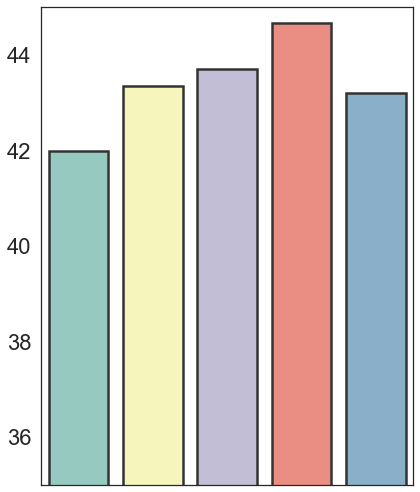

In [31]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(6,7))
sns.barplot(x="ModelName",y="AIC",
            edgecolor=".2", linewidth=2.5,
            palette="Set3",
            data=modelComparisonDf, ax=ax)
# ax.tick_params(labelsize=42)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(35,45)
ax.set_xticks([])
plt.tight_layout()
plt.savefig("./figures/treatmentModelComparison_fit_%s.pdf"%cellLine)

### b) r2 value for predictions to intermittent data

In [21]:
modelComparisonDf = pd.read_csv("./fits/treatmentModel/modelComparisonDf_100uM_OVCAR3.csv", index_col=0)

# Load models and simulate
tmpDicList = []
tmpDfList = []
for _, (modelName, n_steps) in modelComparisonDf[['ModelName', 'n_steps']].iterrows():
    for delay in [1,2,4,7]:
        currTestingDataDf_avg = dataDf_all[dataDf_all.Delay==delay].groupby(by="Time").mean().reset_index()
        # Due to the different format of the 2-compartment and multi-compartment models they need
        # to be loaded in slightly diffrerent ways. Deal with that here.
        modelType = Lookup_modelType(modelName)
        if modelName=="singleStep_extraDivs":
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
            model_kws = {}
            initialConditionsList = {"P0":currTestingDataDf_avg.Confluence.iloc[0], "A0":0}
        else:
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName, "n_steps_%d"%(n_steps))
            model_kws = {"n_steps":int(n_steps)}
            initialConditionsList = {"P00":currTestingDataDf_avg.Confluence.iloc[0], "P10":0, "A0":0}
        # Carry out the model simulations to obtain the confidence intervals.
        fitObj,myModel = LoadFit(modelType,fitDir=currOutDir)
        # 1) Obtain the accuracy of the prediction based on the ML estimates
        resultsDf_MLE = benchmark_prediction_accuracy(fitObj=fitObj, 
                                                       bootstrapResultsDf=pd.DataFrame([myModel.paramDic]),
                                                       dataDf=currTestingDataDf_avg,
                                                       model_kws=model_kws,
                                                       initialConditionsList=initialConditionsList,
                                                       show_progress=False, solver_kws=solver_kws_bootstrapping)
        # 2) Obtain confidence intervals by performing predictions using the 
        # estimates obtained from bootstrapping
        bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
        resultsDf_bootstrapping = benchmark_prediction_accuracy(fitObj=fitObj, 
                                                           bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                           dataDf=currTestingDataDf_avg,
                                                           model_kws=model_kws,
                                                           initialConditionsList=initialConditionsList,
                                                           show_progress=True, solver_kws=solver_kws_bootstrapping)
        # 3) Assemble results
        tmpDicList.append({"ModelName": modelName, "Delay": delay, 
                           "Prediction_MLE": resultsDf_MLE['rSquared'].values[0],
                           "Lower_Bound": np.percentile(resultsDf_bootstrapping['rSquared'].values, (1 - ci_significanceLevel) * 100 / 2),
                           "Upper_Bound": np.percentile(resultsDf_bootstrapping['rSquared'].values,
                                                        (ci_significanceLevel + (1 - ci_significanceLevel) / 2) * 100)})
benchmarkingResultsDf = pd.DataFrame(tmpDicList)

100%|██████████| 25/25 [00:00<00:00, 52.45it/s]


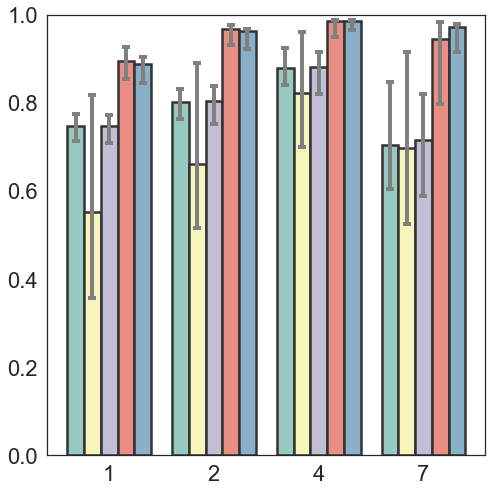

In [22]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.barplot(x="Delay",y="Prediction_MLE",hue="ModelName",
            edgecolor=".2",linewidth=2.5,
            palette="Set3",
            data=benchmarkingResultsDf,ax=ax)
# Plot error bars using the CI estimates obtained from bootstrapping. As these are
# custom error bars and this is a nested plot, needed to write some of my own code to
# get those error bars put into the right place
# Get x-position of bars
n_categories = len(benchmarkingResultsDf['ModelName'].unique())
bar_width = 0.8/n_categories # 0.8 is the default width value according to the docs
errBarDf = benchmarkingResultsDf.copy()
for i,delay in enumerate(benchmarkingResultsDf['Delay'].unique()):
    # for each delay value, get the positions of the mid-points of the bars
    barPosList = [i+x*bar_width+bar_width/2 for x in np.arange(-n_categories/2,n_categories/2)]
    errBarDf.loc[errBarDf.Delay==delay,'Delay'] = barPosList

ax.errorbar(x=errBarDf['Delay'], 
            y=errBarDf['Prediction_MLE'],
            yerr=np.array([errBarDf['Prediction_MLE']-errBarDf['Lower_Bound'],
                           errBarDf['Upper_Bound']-errBarDf['Prediction_MLE']]), 
            fmt='none', c='grey', capsize=4, elinewidth=4, capthick=4)

# Decorate plot
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(0,1)
plt.legend().remove()
plt.tight_layout()
plt.savefig("./figures/treatmentModelComparison_prediction_%s.pdf"%cellLine)

### c) Plot model parameters

In [51]:
# Assemble parameter estimates and confidence intervals
tmpList = []
for _, (modelName, n_steps) in modelComparisonDf[['ModelName', 'n_steps']].iterrows():
    # For the single compartment model (Model 3) there is only a single fit, so use that. For the
    # multi-compartment models choose the best one among the different n_step values.
    if modelName=="singleStep_extraDivs":
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
    else:
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName, "n_steps_%d"%(n_steps))
    
    # Compute confidence intervals
    bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
    fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)
    tmpDf = compute_confidenceInterval_parameters(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx 
                                                  alpha=ci_significanceLevel)
    tmpDf['Model'] = modelName
    tmpDf['CellLine'] = cellLine
    tmpList.append(tmpDf)
paramsDf = pd.concat(tmpList)

  Parameter  Estimate_MLE   Lower_Bound  Upper_Bound        Model CellLine
0     alpha      0.733322  6.676366e-01     0.826595  equalParams   OVCAR3
2      beta      0.021065  2.499362e-17     0.047472  equalParams   OVCAR3
1       d_A      0.408359  1.229276e-01     0.995160  equalParams   OVCAR3
0       xxx   -100.000000 -1.000000e+02  -100.000000         -100     -100
  Parameter  Estimate_MLE   Lower_Bound  Upper_Bound   Model CellLine
3     alpha      0.745503  5.860709e-01     0.947379  2phase   OVCAR3
1      beta      0.000001  3.609687e-38     0.103064  2phase   OVCAR3
0       d_A      0.092812  8.423499e-02     3.012701  2phase   OVCAR3
2     gamma      2.365624  5.524214e-01     3.786249  2phase   OVCAR3
  Parameter  Estimate_MLE  Lower_Bound  Upper_Bound                 Model  \
1     alpha      0.696163     0.576013     0.756100  singleStep_extraDivs   
0       xxx   -100.000000  -100.000000  -100.000000                  -100   
0       d_A      0.109165     0.095761     0

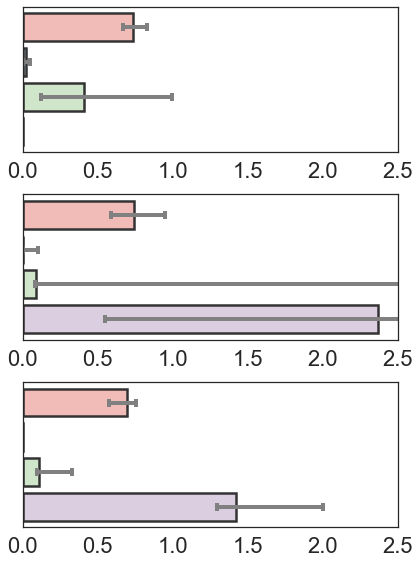

In [102]:
fig, axList = plt.subplots(3,1,figsize=(6,8))
for i,modelName in enumerate(["equalParams", "2phase", "singleStep_extraDivs"]):
    ax = axList[i]
    currDataDf = paramsDf[paramsDf.Model==modelName]
    # Add a "phantom" entry for Model 2 in order to get parameters in all models to align
    if modelName!="2phase":
        phantomRow = currDataDf.iloc[:1].copy()
        phantomRow.loc[:] = -100
        phantomRow['Parameter'] = "xxx"
        currDataDf = pd.concat([currDataDf,phantomRow])    
    # Sort parameters for all models in the same order
    if modelName=="equalParams": plottingOrder = {"alpha":0, "beta":1, "d_A":2}
    if modelName=="2phase": plottingOrder = {"alpha":0, "beta":1, "d_A":2}
    if modelName=="singleStep_extraDivs": plottingOrder = {"alpha":0, "xxx":1, "d_A":2}
    currDataDf = currDataDf.sort_values(by=['Parameter'], key=lambda x: x.map(plottingOrder))
    print(currDataDf)
    sns.barplot(x="Estimate_MLE",y="Parameter",
                edgecolor=".2",linewidth=2.5,
                palette="Pastel1",
                data=currDataDf,ax=ax)
    # Extract and plot error bars
    ax.errorbar(x=currDataDf["Estimate_MLE"], 
                y=np.arange(currDataDf.shape[0]),
                xerr=np.array([currDataDf['Estimate_MLE']-currDataDf['Lower_Bound'],
                               currDataDf['Upper_Bound']-currDataDf['Estimate_MLE']]), 
                fmt='none', c='grey', capsize=4, elinewidth=4, capthick=4)
    # Decorate plot
    ax.set_xlim(0,2.5)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_yticks([])
plt.tight_layout()
plt.savefig("./figures/params_treatmentModel_%s.pdf"%cellLine)

In [101]:
paramsDf[np.isin(paramsDf,["equalParams", "2phase", "singleStep_extraDivs"])]

,Parameter,Estimate_MLE,Lower_Bound,Upper_Bound,Model,CellLine
0,alpha,0.733322,6.676366e-01,0.826595,equalParams,OVCAR3
1,d_A,0.408359,1.229276e-01,0.995160,equalParams,OVCAR3
2,beta,0.021065,2.499362e-17,0.047472,equalParams,OVCAR3
0,d_A,0.092812,8.423499e-02,3.012701,2phase,OVCAR3
1,beta,0.000001,3.609687e-38,0.103064,2phase,OVCAR3
2,gamma,2.365624,5.524214e-01,3.786249,2phase,OVCAR3
3,alpha,0.745503,5.860709e-01,0.947379,2phase,OVCAR3
0,d_A,0.109165,9.576092e-02,0.330564,singleStep_extraDivs,OVCAR3
1,alpha,0.696163,5.760125e-01,0.756100,singleStep_extraDivs,OVCAR3
2,phi,1.422331,1.296313e+00,2.000000,singleStep_extraDivs,OVCAR3


## Supplementary Figure 4: Development of the treatment model for Ovcar4

In [35]:
# Data and solver configurations
cellLine = "OVCAR4"
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':2}
# Due to the random perturbations during bootstrapping the ODE solver can fail whilst fitting 
# to the synthetic data. To fix this, use more stringent solver arguments
solver_kws_bootstrapping = solver_kws.copy()
solver_kws_bootstrapping['max_step'] = 0.5

# Load growth model parameters
growthModel = "GeneralisedLogistic"
fitObj,_ = LoadFit(growthModel,fitDir=os.path.join("./fits/growthModel/%s"%cellLine,growthModel))
params_growth = fitObj.params
params_growth['r'].set(vary=False)
params_growth['K'].set(vary=False)
params_growth['v'].set(vary=False)
params_growth['N0'].set(vary=False)
growthModelBootstrapsDf = pd.read_csv(os.path.join("./fits/growthModel/%s"%cellLine, growthModel, "bootstraps.csv"), index_col=0)

# Parameters for the multi-step model
nStepsList = np.arange(1,5) # Which parameter values for n_steps to examine
treatmentModelsList = ["singleStep", "multiStep_equalParams", 
                       "multiStep_varying_r", "multiStep_varying_alpha", 
                       "multiStep_2phase", "singleStep_extraDivs"]
multiStepModelList = [x for x in treatmentModelsList if x.split("_")[0]=="multiStep"]
params = params_growth.copy()
params.add('alpha', value=0.75, min=0, max=1, vary=True)
params.add('beta', value=0.1, min=0, max=5e-1, vary=True)
params.add('gamma', value=0.1, min=0, max=4, vary=True)
params.add('phi', value=5e-1, min=0, max=2, vary=True)
params.add('d_A', value=5e-2, min=0, max=4, vary=True)
params.add('n_steps', value=2, min=1, max=5, vary=False)
# Assume that all accumulating damage does not alter the proliferation rate (r) or sensitivity to drug (alpha)
for x in range(params['n_steps'].max):
    params.add('r%d'%x, value=params['r'].value, min=params['r'].min, max=params['r'].max, vary=False)
for x in range(params['n_steps'].max):
    params.add('alpha%d'%x, value=params['alpha'].value, min=params['alpha'].min, max=params['alpha'].max, vary=False)
# Assume that initially all cells are in the P compartment
params.add('P0', value=10, min=0, max=100., vary=False) # Only used in the 2 compartment models
for x in range(params['n_steps'].max): # Only used in the multi-compartment models
    params.add('P%d0'%x, value=0, vary=False)
params.add('A0', value=0, vary=False)

# Environment
dataDir = "./data/"
modelDir = "./fits/"

In [10]:
# Load the treatment data for model development and testing
dataDf_all = pd.read_csv("./data/intermittentTreatmentDf_cleaned.csv", index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DMax==100) & (dataDf_all.CellLine==cellLine)] # Only select 100uM experiment here. Will use 50uM when developing the dose-resoponse model

# For model development, use the data for CT treatment. For OVCAR4 we had to exclude the last 4 data points as 
# the build-up of debris confounded the measurements of alive cells.
trainingDataDf_all = dataDf_all[dataDf_all.Delay==100]
if cellLine=="OVCAR4": trainingDataDf_all = trainingDataDf_all[np.isnan(trainingDataDf_all['Confluence'])==False]
trainingDataDf_avg = trainingDataDf_all.groupby(by="Time").mean().reset_index()

# For model testing, use the data from the 7d-on experiment
testingDataDf_all = dataDf_all[dataDf_all.Delay==7]
testingDataDf_avg = testingDataDf_all.groupby(by="Time").mean().reset_index()

### Model Fitting

#### Model 1: Immediate arrest

In [7]:
# Setup environment
modelType = "CycleArrestModel_singleStep"
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType)

In [8]:
if runFitting:
    # Setup env
    utils.mkdir(currModelOutDir)
    tmpModel = MakeModelFromStr(modelType)
    currParams = Parameters()    
    currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
    if currParams['P0'].vary==False: currParams['P0'].value = trainingDataDf_avg.Confluence.iloc[0]    

    # Fit
    fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
    fitObj.fitId = 0
    fitObj.modelName = modelType
    fitObj.data = trainingDataDf_avg
    fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

    # Post-process
    pickle.dump(obj=fitObj, file=open(os.path.join(currModelOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0765e+02                                    4.46e+03    
       1              2         3.6145e+02      3.46e+02       1.33e-01       3.81e+03    
       2              5         3.3778e+02      2.37e+01       2.72e-02       1.44e+03    
       3              6         3.0934e+02      2.84e+01       5.36e-02       3.72e+03    
       4              7         2.9410e+02      1.52e+01       5.32e-02       2.10e+03    
       5              8         2.8081e+02      1.33e+01       2.20e-02       6.31e+01    
       6              9         2.6324e+02      1.76e+01       2.61e-02       4.91e+01    
       7             11         2.6119e+02      2.05e+00       1.72e-03       4.87e+00    
       8             12         2.5773e+02      3.45e+00       2.60e-03       3.45e+00    
       9             14         2.5680e+02      9.38e-01       1.44e-03       1.72e+00    

In [9]:
# Uncertainty Estimation
if runFitting:
    # Turn off verboseness for bootstrapping
    optimiser_kws_bootstrapping = optimiser_kws.copy()
    optimiser_kws_bootstrapping['verbose'] = 0
    # Run bootstrapping
    perform_bootstrap(fitObj=LoadFit(modelType,fitDir=currModelOutDir)[0],
                      prior_experiment_df=growthModelBootstrapsDf,
                      n_bootstraps=n_bootstraps, show_progress=True,
                      solver_kws=solver_kws, optimiser_kws=optimiser_kws_bootstrapping, 
                      outName=os.path.join(currModelOutDir, "bootstraps.csv"))

100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


#### Model 2: Multiple steps to cell cycle arrest

##### Assume all parameters remain the same as the cell accumulates damage

In [10]:
# Setup environment
modelType = Lookup_modelType("multiStep_equalParams")
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_equalParams")

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelType, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Allow r to change once the cell has been hit
        currParams.add(params['r'])
        currParams.add(params['alpha'])
        for x in range(n_steps): # Set alpha and r to be the same for all compartments
            currParams['r%d'%x].set(expr='r', vary=False)
            currParams['alpha%d'%x].set(expr='alpha', vary=False)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelType
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0765e+02                                    4.46e+03    
       1              2         3.6145e+02      3.46e+02       1.33e-01       3.81e+03    
       2              5         3.3778e+02      2.37e+01       2.72e-02       1.44e+03    
       3              6         3.0934e+02      2.84e+01       5.36e-02       3.72e+03    
       4              7         2.9410e+02      1.52e+01       5.32e-02       2.10e+03    
       5              8         2.8081e+02      1.33e+01       2.20e-02       6.31e+01    
       6              9         2.6323e+02      1.76e+01       2.61e-02       4.89e+01    
       7             11         2.6119e+02      2.05e+00       1.72e-03       4.87e+00    
       8             12         2.5773e+02      3.45e+00       2.60e-03       3.46e+00    
       9             14         2.5679e+02      9.38e-01       1.44e-03       1.73e+00    

##### Varying growth rates as damage is accumulated

In [11]:
# Setup environment
modelType = Lookup_modelType("multiStep_varying_r")
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_varying_r")

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelType, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Allow r to change once the cell has been hit
        currParams.add(params['r'])
        currParams.add(params['alpha'])
        currParams['r0'].set(expr='r', vary=False) # growth rate of proliferating population is fixed as it was determined from the control experiments
        currParams['alpha0'].set(expr='alpha', vary=False) # assume alpha doesn't change as damage accumulates. Need this extra line as for loop in next line starts at n_steps=1.
        for x in range(1, n_steps):
            currParams['r%d'%x].set(vary=True) # No constraints on r
            currParams['alpha%d'%x].set(expr='alpha', vary=False)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelType
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0765e+02                                    4.46e+03    
       1              2         3.6145e+02      3.46e+02       1.33e-01       3.81e+03    
       2              5         3.3778e+02      2.37e+01       2.72e-02       1.44e+03    
       3              6         3.0934e+02      2.84e+01       5.36e-02       3.72e+03    
       4              7         2.9410e+02      1.52e+01       5.32e-02       2.10e+03    
       5              8         2.8081e+02      1.33e+01       2.20e-02       6.31e+01    
       6              9         2.6323e+02      1.76e+01       2.61e-02       4.89e+01    
       7             11         2.6119e+02      2.05e+00       1.72e-03       4.87e+00    
       8             12         2.5773e+02      3.45e+00       2.60e-03       3.46e+00    
       9             14         2.5679e+02      9.38e-01       1.44e-03       1.73e+00    

      65             74         9.7602e+01      3.32e-05       2.49e-04       1.39e+00    
      66             75         9.7602e+01      2.06e-05       4.06e-04       2.55e+00    
      67             76         9.7602e+01      3.37e-05       2.50e-04       1.44e+00    
      68             77         9.7602e+01      2.59e-05       3.08e-04       2.40e+00    
      69             78         9.7602e+01      3.40e-05       2.81e-04       1.38e+00    
      70             79         9.7602e+01      4.30e-05       9.44e-05       1.80e+00    
      71             80         9.7602e+01      3.71e-05       2.36e-04       1.01e+00    
      72             81         9.7602e+01      2.92e-05       2.45e-04       1.80e+00    
      73             82         9.7602e+01      3.17e-05       2.49e-04       1.24e+00    
      74             83         9.7602e+01      2.43e-05       3.14e-04       2.30e+00    
      75             84         9.7602e+01      3.25e-05       2.50e-04       1.39e+00    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7898e+04                                    4.47e+04    
       1              2         1.7779e+03      1.61e+04       1.84e+00       8.54e+03    
       2              3         2.3755e+02      1.54e+03       4.92e-01       1.16e+03    
       3              4         1.6446e+02      7.31e+01       4.81e-01       1.79e+03    
       4              5         1.1460e+02      4.99e+01       2.98e-01       3.49e+02    
       5              6         1.0521e+02      9.38e+00       2.95e-01       7.51e+02    
       6              7         1.0126e+02      3.95e+00       1.52e-01       6.66e+01    
       7              8         1.0073e+02      5.30e-01       1.84e-01       2.63e+01    
       8              9         1.0047e+02      2.67e-01       2.92e-01       1.46e+01    
       9             10         1.0000e+02      4.62e-01       2.24e-01       2.08e+01    

##### Varying kill rates as damage is accumulated

In [12]:
# Setup environment
modelType = Lookup_modelType("multiStep_varying_alpha")
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_varying_alpha")

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelType, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Allow r to change once the cell has been hit
        currParams.add(params['r'])
        currParams['r0'].set(expr='r', vary=False) # growth rate of proliferating population is fixed as it was determined from the control experiments
        currParams['alpha0'].set(vary=True) # Need this extra line as for loop in next line starts at n_steps=1.
        for x in range(1, n_steps):
            currParams['r%d'%x].set(expr='r', vary=False)
            currParams['alpha%d'%x].set(vary=True)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelType
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0765e+02                                    4.46e+03    
       1              2         3.6145e+02      3.46e+02       1.33e-01       3.81e+03    
       2              5         3.3778e+02      2.37e+01       2.72e-02       1.44e+03    
       3              6         3.0934e+02      2.84e+01       5.36e-02       3.72e+03    
       4              7         2.9410e+02      1.52e+01       5.32e-02       2.10e+03    
       5              8         2.8081e+02      1.33e+01       2.20e-02       6.31e+01    
       6              9         2.6324e+02      1.76e+01       2.61e-02       4.90e+01    
       7             11         2.6119e+02      2.05e+00       1.72e-03       4.87e+00    
       8             12         2.5773e+02      3.45e+00       2.60e-03       3.45e+00    
       9             14         2.5680e+02      9.38e-01       1.44e-03       1.73e+00    

       7              8         2.6007e+03      4.49e-03       4.85e-07       4.99e-09    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.0443e+04, final cost 2.6007e+03, first-order optimality 4.99e-09.


#### Model 3: Drug dependent and independent steps

In [51]:
# Setup environment
modelType = Lookup_modelType("multiStep_2phase")
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType)

In [52]:
if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelType, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Assume r and alpha are the same across all populations
        currParams.add(params['r'])        
        currParams.add(params['alpha'])
#         currParams['beta'].set(value=0, vary=False)
        for x in range(n_steps):
            currParams['r%d'%x].set(expr='r', vary=False)
            currParams['alpha%d'%x].set(expr='alpha', vary=False)
        currParams['r%d'%(x+1)].set(expr='r', vary=False)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelType
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0118e+04                                    6.54e+04    
       1              2         5.6096e+02      1.96e+04       1.33e+00       5.09e+03    
       2              3         1.1157e+02      4.49e+02       8.56e-02       6.44e+02    
       3              4         1.1009e+02      1.48e+00       5.39e-02       2.18e+02    
       4              6         1.0966e+02      4.35e-01       3.06e-02       1.06e+02    
       5              7         1.0943e+02      2.32e-01       6.22e-02       3.40e+02    
       6              8         1.0886e+02      5.65e-01       9.49e-02       2.70e+02    
       7              9         1.0860e+02      2.64e-01       1.18e-01       3.06e+02    
       8             10         1.0776e+02      8.32e-01       1.10e-01       1.91e+02    
       9             12         1.0722e+02      5.48e-01       4.34e-02       3.69e+01    

       7              8         5.0788e+03      3.50e-06       7.28e-10       7.76e-12    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.1572e+04, final cost 5.0788e+03, first-order optimality 7.76e-12.


In [54]:
# Compare fits for different numbers of n_step
tmpList_subModel = []
for n_steps in nStepsList:
    currOutDir = os.path.join(currModelOutDir, "n_steps_%d"%(n_steps))
    fitObj,_ = LoadFit(modelType,fitDir=currOutDir)    
    tmpList_subModel.append({"ModelName":modelType, "n_steps":n_steps,
                    "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
tmpDf = pd.DataFrame(tmpList_subModel)
tmpDf

,ModelName,n_steps,r2,AIC,BIC
0,CycleArrestModel_multiStep_2phase,1,0.643924,45.227374,47.783603
1,CycleArrestModel_multiStep_2phase,2,0.653177,44.858755,47.414984
2,CycleArrestModel_multiStep_2phase,3,-0.227894,62.558133,65.114362
3,CycleArrestModel_multiStep_2phase,4,-17.087386,100.216930,102.773159


In [55]:
# This shows that both n=1 and n=2 fit almost equally as well. However, n=1 does a lot better on the 
# prediction. Thus, going forward, we will choose n=1 for the analysis.

#### Identify best fitting #Hits (n) value for each multi-step model (Models 2 & 3) and perform uncertainty estimation for this value

In [32]:
modelsToBootstrapList = ["multiStep_equalParams", "multiStep_varying_r", "multiStep_varying_alpha", "multiStep_2phase"]

In [33]:
# Assemble goodness-of-fit quantifications to identify best fitting model for each model
tmpList_total = []
for modelName in modelsToBootstrapList:
    tmpList_subModel = []
    for n_steps in nStepsList:
        # For Model 3 the model fits almost identitically well for n=1 and n=2, but it has 
        # better predictive performance for n=1, so choose this to carry forward for analysis.
        if modelName=="multiStep_2phase": n_steps = 1
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName, "n_steps_%d"%(n_steps))
        fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)    
        tmpList_subModel.append({"ModelName":modelName.split("multiStep_")[-1], "n_steps":n_steps,
                        "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
    tmpDf = pd.DataFrame(tmpList_subModel)
    tmpList_total.append(tmpDf.loc[tmpDf.AIC.idxmin()])
modelComparisonDf = pd.DataFrame(tmpList_total)

In [34]:
# Turn off verboseness for bootstrapping
optimiser_kws_bootstrapping = optimiser_kws.copy()
optimiser_kws_bootstrapping['verbose'] = 0

if runFitting:
    # Use multi-threading to speed up computation
    pool = mp.Pool(processes=nProcesses)
    def bootstrapJob(job):
        fitObj, n_steps, outName = job
        return perform_bootstrap(fitObj=fitObj,
                          prior_experiment_df=growthModelBootstrapsDf,
                          model_kws={"n_steps":n_steps},
                          n_bootstraps=n_bootstraps, show_progress=True,
                          solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws_bootstrapping, 
                          outName=outName)    
    jobList = []
    for _, (modelName, n_steps) in modelComparisonDf[['ModelName', 'n_steps']].iterrows():
        modelType = Lookup_modelType(modelName)
        outDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName.split("multiStep_")[-1], "n_steps_%d"%(n_steps))
        fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=outDir)
        jobList.append([fitObj,n_steps,os.path.join(outDir, "bootstraps.csv")])
#     [bootstrapJob(x) for x in jobList]
    list(tqdm(pool.imap(bootstrapJob, jobList), total=len(jobList)));

100%|██████████| 4/4 [02:38<00:00, 39.54s/it]


#### Model 4: 2-compartment model with extra divisions

In [9]:
# Setup environment
modelType = Lookup_modelType("singleStep_extraDivs")
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType)

In [10]:
if runFitting:
    # Setup env
    utils.mkdir(currModelOutDir)
    tmpModel = MakeModelFromStr(modelType)
    currParams = Parameters()
    currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
    if currParams['P0'].vary==False: currParams['P0'].value = trainingDataDf_avg.Confluence.iloc[0]    

    # Fit
    fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
    fitObj.fitId = 0
    fitObj.modelName = modelType
    fitObj.data = trainingDataDf_avg
    fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

    # Post-process
    pickle.dump(obj=fitObj, file=open(os.path.join(currModelOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3023e+02                                    1.80e+03    
       1              2         1.3209e+02      9.81e+01       2.23e-01       2.33e+03    
       2              3         1.0694e+02      2.51e+01       2.22e-01       4.92e+03    
       3              4         1.0194e+02      5.00e+00       8.75e-02       8.37e+00    
       4              7         1.0170e+02      2.42e-01       2.02e-02       1.98e+02    
       5              8         1.0129e+02      4.04e-01       3.73e-02       9.80e+02    
       6              9         1.0075e+02      5.47e-01       6.54e-02       2.11e+03    
       7             10         9.9927e+01      8.20e-01       3.41e-02       4.48e+02    
       8             11         9.9468e+01      4.59e-01       6.98e-02       2.05e+03    
       9             12         9.8933e+01      5.36e-01       2.62e-02       1.70e+02    

In [11]:
# Uncertainty Estimation
if runFitting:
    # Turn off verboseness for bootstrapping
    optimiser_kws_bootstrapping = optimiser_kws.copy()
    optimiser_kws_bootstrapping['verbose'] = 0
    # Run bootstrapping
    perform_bootstrap(fitObj=LoadFit(modelType,fitDir=currModelOutDir)[0],
                      shuffle_params=False, # Turn this off as there are multiple optima in this case and we don't want to sample from the worse optimum
                      prior_experiment_df=growthModelBootstrapsDf,
                      n_bootstraps=n_bootstraps, show_progress=True,
                      solver_kws=solver_kws, optimiser_kws=optimiser_kws_bootstrapping, 
                      outName=os.path.join(currModelOutDir, "bootstraps.csv"))

100%|██████████| 25/25 [00:07<00:00,  3.42it/s]


### a) Plot best fit for each model and the predictions for the intermittent data

In [11]:
modelsToPlotList = ["singleStep", "multiStep_equalParams", "multiStep_2phase", "singleStep_extraDivs"]

In [12]:
# Assemble goodness-of-fit quantifications to identify best fitting model for each model
tmpList_total = []
for modelName in treatmentModelsList:
    # For the single compartment models (Models 1 & 3) there is only a single fit, so use that. For the
    # multi-compartment models choose the best one among the different n_step values.
    if modelName=="singleStep" or modelName=="singleStep_extraDivs":
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
        fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)    
        tmpList_total.append(pd.Series({"ModelName":modelName, "n_steps":np.nan,
                        "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic}))
    else:
        tmpList_subModel = []
        for n_steps in nStepsList:
            # For Model 3 the model fits almost identitically well for n=1 and n=2, but it has 
            # better predictive performance for n=1, so choose this to carry forward for analysis.
            if modelName=="multiStep_2phase": n_steps = 1
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName, "n_steps_%d"%(n_steps))
            fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)    
            tmpList_subModel.append({"ModelName":modelName, "n_steps":n_steps,
                            "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
        tmpDf = pd.DataFrame(tmpList_subModel)
        tmpList_total.append(tmpDf.loc[tmpDf.AIC.idxmin()])
modelComparisonDf = pd.DataFrame(tmpList_total)
modelComparisonDf.to_csv("./fits/treatmentModel/modelComparisonDf_100uM_OVCAR4.csv")

#### Model fits

In [81]:
# Load models and simulate
tmpDfList = []
for modelName in modelsToPlotList:
    n_steps = modelComparisonDf.loc[modelComparisonDf['ModelName']==modelName,'n_steps'].values[0]
    # Due to the different format of the 2-compartment and multi-compartment models they need
    # to be loaded in slightly different ways. Deal with that here.
    modelType = Lookup_modelType(modelName)
    if modelName=="singleStep" or modelName=="singleStep_extraDivs":
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
        model_kws = {}
        initialConditionsList = {"P0":trainingDataDf_avg.Confluence.iloc[0], "A0":0}
    else:
        if modelName=="multiStep_equalParams":
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName.split("multiStep_")[-1], "n_steps_%d"%(n_steps))
        else:
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType, "n_steps_%d"%(n_steps))
        model_kws = {"n_steps":int(n_steps)}
        initialConditionsList = {"P00":trainingDataDf_avg.Confluence.iloc[0], "P10":0, "A0":0}
    # Carry out the model simulations to obtain the confidence intervals.
    fitObj,_ = LoadFit(modelType,fitDir=currOutDir)  
    bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
    modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, 
                                                        bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                        treatmentScheduleList=utils.ExtractTreatmentFromDf(trainingDataDf_avg),
                                                        model_kws=model_kws, 
                                                        initialConditionsList=initialConditionsList,
                                                        show_progress=True, n_time_steps=100,
                                                        alpha=ci_significanceLevel,
                                                        solver_kws=solver_kws_bootstrapping)
    modelFitsDf['ModelName'] = modelName
    tmpDfList.append(modelFitsDf)
fitComparisonDf = pd.concat(tmpDfList)

100%|██████████| 25/25 [00:00<00:00, 73.09it/s]


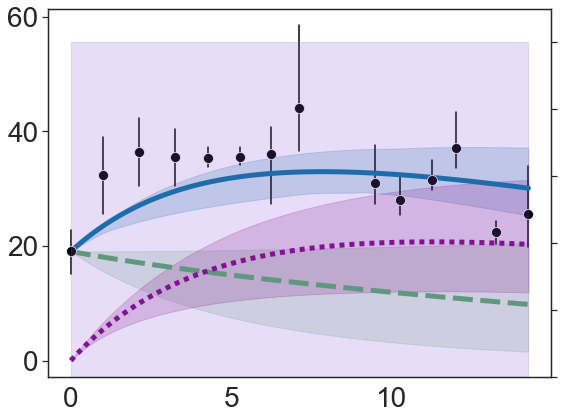

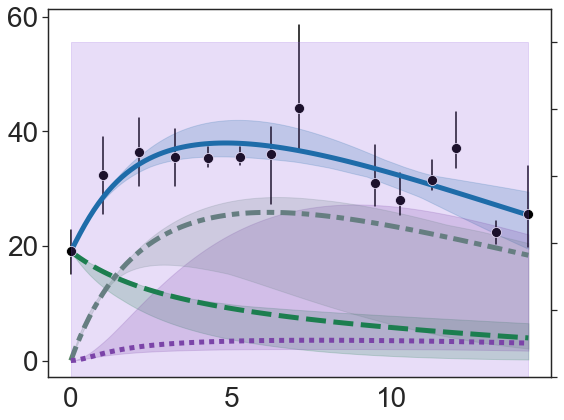

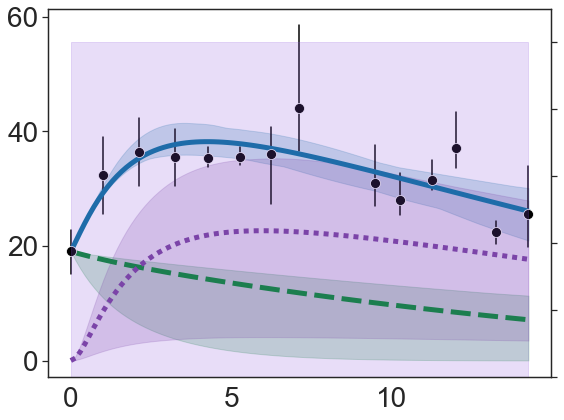

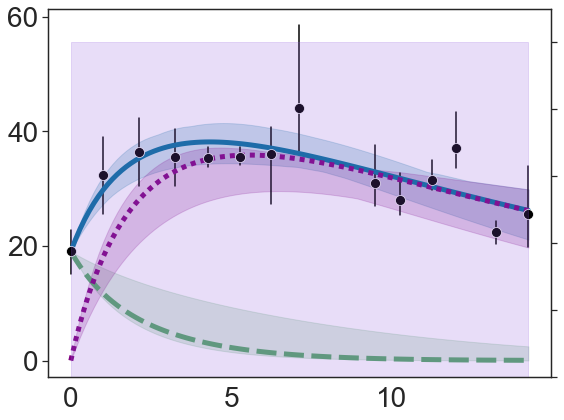

In [82]:
for modelName in modelsToPlotList:
    n_steps = modelComparisonDf.loc[modelComparisonDf['ModelName']==modelName,'n_steps'].values[0]
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    # 1. Plot the model predictions and associated confidence intervals
    currModelPredictionsDf = fitComparisonDf[(fitComparisonDf.ModelName==modelName)]
    if modelName=="2phase": variableList = ["TumourSize","P0","A","P1"]
    elif modelName=="singleStep": variableList = ["TumourSize","P","A"]
    elif modelName=="singleStep_extraDivs": variableList = ["TumourSize","P","A"]
    else: variableList = ["TumourSize","P0","A"]+["P%d"%x for x in range(1,int(n_steps))]
    currPalette = multiStepPalette if modelName.split("_")[0]!="singleStep" else cycleArrestModelPalette        
    sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=5, palette=currPalette,
                 style_order=variableList,
                 legend=False,
                 data=currModelPredictionsDf, ax=ax)
    for var in variableList:
        currDataDf = currModelPredictionsDf[currModelPredictionsDf.Variable==var]
        ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                         currDataDf['CI_Upper_Bound'], color=currPalette[var], alpha=0.2)
    # 2. Plot the data
    sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=trainingDataDf_all, ax=ax)
    # 3. Plot the drug concentration
    tmpDf = trainingDataDf_avg.copy()
    tmpDf.Confluence = np.nan
    PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
    ax.tick_params(labelsize=28)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig("./figures/fitComparison_CT_100uM_%s_%s.pdf"%(cellLine,modelName))

In [83]:
modelComparisonDf

,ModelName,n_steps,r2,AIC,BIC
Unnamed 0,singleStep,NaN,0.087347,56.404325,58.321497
1,multiStep_equalParams,2.0,0.647014,43.105353,45.022525
1,multiStep_varying_r,2.0,0.652419,44.889307,47.445536
1,multiStep_varying_alpha,2.0,0.647077,45.102852,47.659082
0,multiStep_2phase,1.0,0.643924,45.227374,47.783603
Unnamed 1,singleStep_extraDivs,NaN,0.650270,42.975613,44.892785


#### Model predictions

In [13]:
# Load models and simulate
tmpDfList = []
for modelName in modelsToPlotList:
    n_steps = modelComparisonDf.loc[modelComparisonDf['ModelName']==modelName,'n_steps'].values[0]
    for delay in [1,2,4,7]:
        currTestingDataDf_avg = dataDf_all[dataDf_all.Delay==delay].groupby(by="Time").mean().reset_index()
        # Due to the different format of the 2-compartment and multi-compartment models they need
        # to be loaded in slightly diffrerent ways. Deal with that here.
        modelType = Lookup_modelType(modelName)
        if modelName=="singleStep" or modelName=="singleStep_extraDivs":
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
            model_kws = {}
            initialConditionsList = {"P0":currTestingDataDf_avg.Confluence.iloc[0], "A0":0}
        else:
            if modelName=="multiStep_equalParams":
                currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName.split("multiStep_")[-1], "n_steps_%d"%(n_steps))
            else:
                currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType, "n_steps_%d"%(n_steps))
            model_kws = {"n_steps":int(n_steps)}
            initialConditionsList = {"P00":currTestingDataDf_avg.Confluence.iloc[0], "P10":0, "A0":0}
        # Carry out the model simulations to obtain the confidence intervals.
        fitObj,_ = LoadFit(modelType,fitDir=currOutDir)  
        bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
        modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, 
                                                            bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                            treatmentScheduleList=utils.ExtractTreatmentFromDf(currTestingDataDf_avg),
                                                            model_kws=model_kws, 
                                                            initialConditionsList=initialConditionsList,
                                                            show_progress=True, n_time_steps=100,
                                                            alpha=ci_significanceLevel,
                                                            solver_kws=solver_kws_bootstrapping)
        modelFitsDf['ModelName'] = modelName
        modelFitsDf['Delay'] = delay
        tmpDfList.append(modelFitsDf)
predictionComparisonDf = pd.concat(tmpDfList)

100%|██████████| 25/25 [00:00<00:00, 51.28it/s]


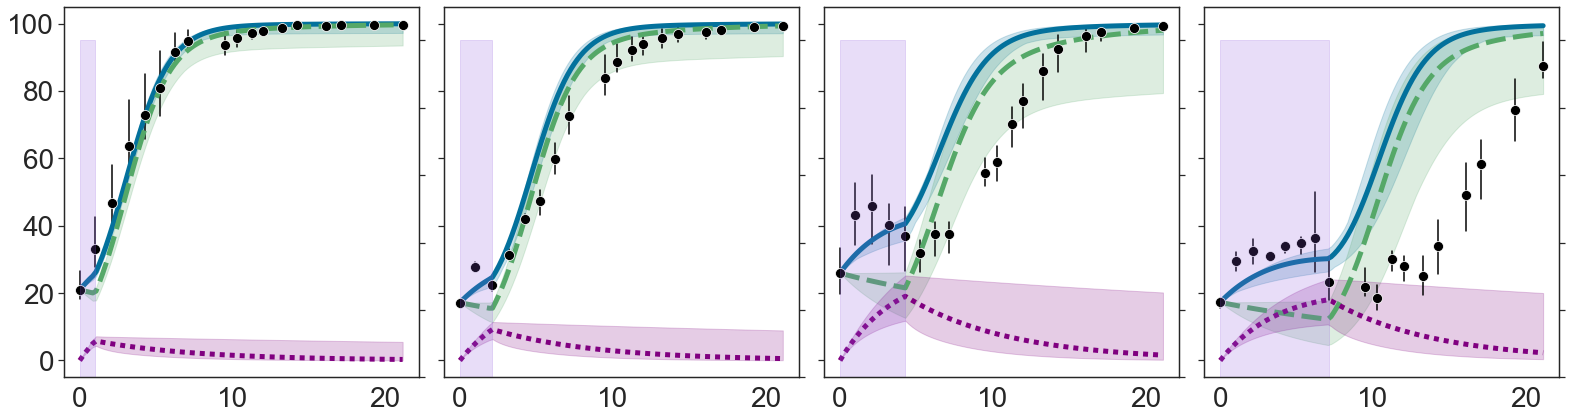

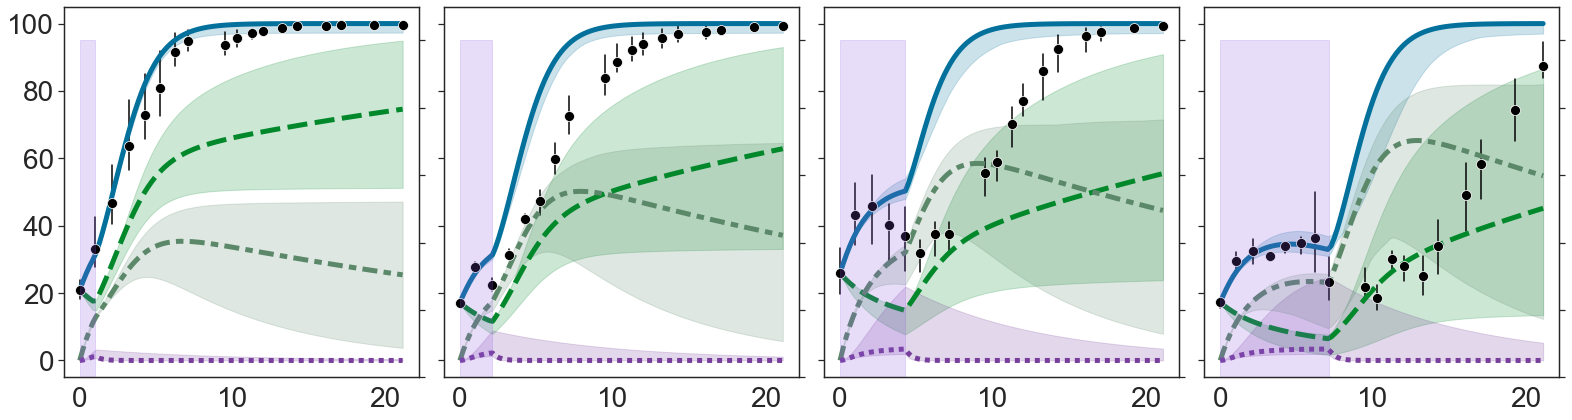

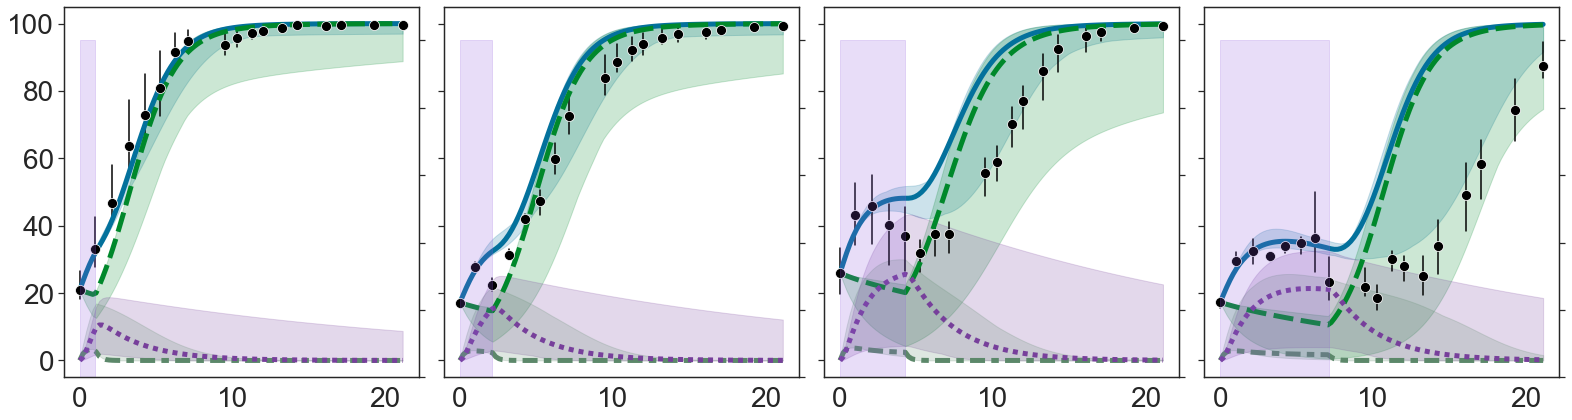

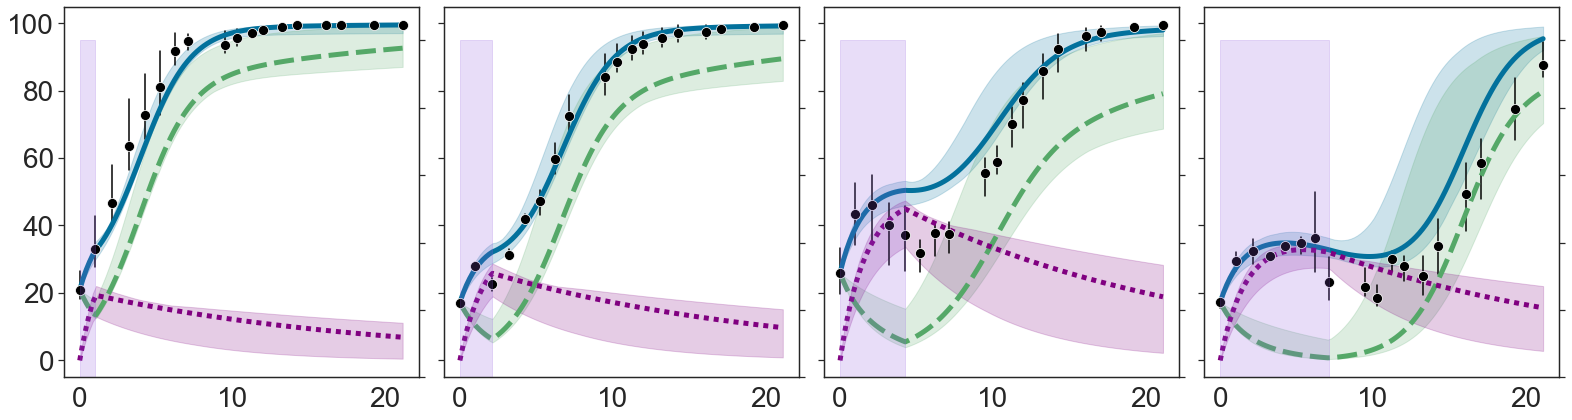

In [17]:
delayList = predictionComparisonDf.Delay.unique()
for modelName in modelsToPlotList:
    n_steps = modelComparisonDf.loc[modelComparisonDf['ModelName']==modelName,'n_steps'].values[0]
    fig, axList = plt.subplots(1,len(delayList),sharex=True,sharey=True,figsize=(22,6))
    for i,delay in enumerate(delayList):
        ax = axList[i]
        # 1. Plot the model predictions and associated confidence intervals
        currModelPredictionsDf = predictionComparisonDf[(predictionComparisonDf.ModelName==modelName) &
                                                        (predictionComparisonDf.Delay==delay)]
        currTestingDataDf_all = dataDf_all[dataDf_all.Delay==delay]
        currTestingDataDf_avg = currTestingDataDf_all.groupby(by="Time").mean().reset_index()
        if modelName=="multiStep_2phase": variableList = ["TumourSize","P0","A","P1"]
        elif modelName=="singleStep" or modelName=="singleStep_extraDivs": variableList = ["TumourSize","P","A"]
        else: variableList = ["TumourSize","P0","A"]+["P%d"%x for x in range(1,int(n_steps))]
        currPalette = multiStepPalette if len(modelName.split("singleStep"))!=2 else cycleArrestModelPalette            
        sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                     lw=5, palette=currPalette,
                     style_order=variableList,
                     legend=False,
                     data=currModelPredictionsDf, ax=ax)
        for var in variableList:
            currDataDf = currModelPredictionsDf[currModelPredictionsDf.Variable==var]
            ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                             currDataDf['CI_Upper_Bound'], color=currPalette[var], alpha=0.2)
        # 2. Plot the data
        sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
                 markers="o", lw=0, markersize=10, color="black",
                 legend=False, data=currTestingDataDf_all, ax=ax)
        # 3. Plot the drug concentration
        tmpDf = currTestingDataDf_avg.copy()
        tmpDf.Confluence = np.nan
        PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
        ax.tick_params(labelsize=28)
        ax.set_xlabel("")
        ax.set_ylabel("")
        plt.tight_layout()
        plt.savefig("./figures/predictionComparison_IMT_100uM_%s_%s.pdf"%(cellLine,modelName))

### c) Quantify goodness-of-fit

In [18]:
modelComparisonDf = pd.read_csv("./fits/treatmentModel/modelComparisonDf_100uM_OVCAR4.csv")

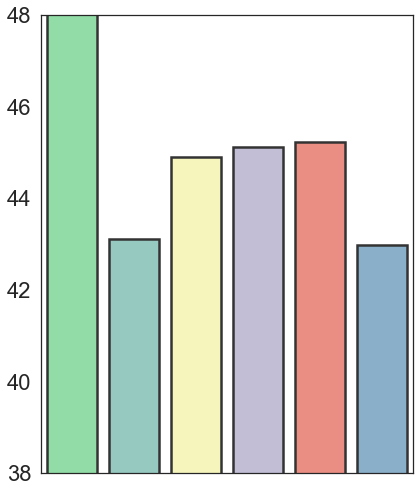

In [19]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(6,7))
sns.barplot(x="ModelName",y="AIC",
            edgecolor=".2", linewidth=2.5,
            palette=[(133./255, 234./255, 161./255)] + sns.color_palette("Set3")[:5],
            data=modelComparisonDf, ax=ax)
# ax.tick_params(labelsize=42)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(38,48)
ax.set_xticks([])
plt.tight_layout()
plt.savefig("./figures/treatmentModelComparison_fit_%s.pdf"%cellLine)

In [20]:
modelComparisonDf

,Unnamed: 0,ModelName,n_steps,r2,AIC,BIC
0,Unnamed 0,singleStep,NaN,0.087347,56.404325,58.321497
1,1,multiStep_equalParams,2.0,0.647014,43.105353,45.022525
2,1,multiStep_varying_r,2.0,0.652419,44.889307,47.445536
3,1,multiStep_varying_alpha,2.0,0.647077,45.102852,47.659082
4,0,multiStep_2phase,1.0,0.643924,45.227374,47.783603
5,Unnamed 1,singleStep_extraDivs,NaN,0.650270,42.975613,44.892785


### c) r2 value for predictions to intermittent data

In [112]:
modelComparisonDf = pd.read_csv("./fits/treatmentModel/modelComparisonDf_100uM_OVCAR4.csv", index_col=0)

# Load models and simulate
tmpDicList = []
tmpDfList = []
for _, (modelName, n_steps) in modelComparisonDf[['ModelName', 'n_steps']].iterrows():
    for delay in [1,2,4,7]:
        currTestingDataDf_avg = dataDf_all[dataDf_all.Delay==delay].groupby(by="Time").mean().reset_index()
        # Due to the different format of the 2-compartment and multi-compartment models they need
        # to be loaded in slightly diffrerent ways. Deal with that here.
        modelType = Lookup_modelType(modelName)
        if modelName=="singleStep" or modelName=="singleStep_extraDivs":
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
            model_kws = {}
            initialConditionsList = {"P0":currTestingDataDf_avg.Confluence.iloc[0], "A0":0}
        else:
            if modelName!="multiStep_2phase":
                currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName.split("multiStep_")[-1], "n_steps_%d"%(n_steps))
            else:
                currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType, "n_steps_%d"%(n_steps))
            model_kws = {"n_steps":int(n_steps)}
            initialConditionsList = {"P00":currTestingDataDf_avg.Confluence.iloc[0], "P10":0, "A0":0}
        # Carry out the model simulations to obtain the confidence intervals.
        fitObj,myModel = LoadFit(modelType,fitDir=currOutDir)
        # 1) Obtain the accuracy of the prediction based on the ML estimates
        resultsDf_MLE = benchmark_prediction_accuracy(fitObj=fitObj, 
                                                       bootstrapResultsDf=pd.DataFrame([myModel.paramDic]),
                                                       dataDf=currTestingDataDf_avg,
                                                       model_kws=model_kws,
                                                       initialConditionsList=initialConditionsList,
                                                       show_progress=False, solver_kws=solver_kws_bootstrapping)
        # 2) Obtain confidence intervals by performing predictions using the 
        # estimates obtained from bootstrapping
        bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
        resultsDf_bootstrapping = benchmark_prediction_accuracy(fitObj=fitObj, 
                                                           bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                           dataDf=currTestingDataDf_avg,
                                                           model_kws=model_kws,
                                                           initialConditionsList=initialConditionsList,
                                                           show_progress=True, solver_kws=solver_kws_bootstrapping)
        # 3) Assemble results
        tmpDicList.append({"ModelName": modelName, "Delay": delay, 
                           "Prediction_MLE": resultsDf_MLE['rSquared'].values[0],
                           "Lower_Bound": np.percentile(resultsDf_bootstrapping['rSquared'].values, (1 - ci_significanceLevel) * 100 / 2),
                           "Upper_Bound": np.percentile(resultsDf_bootstrapping['rSquared'].values,
                                                        (ci_significanceLevel + (1 - ci_significanceLevel) / 2) * 100)})
benchmarkingResultsDf = pd.DataFrame(tmpDicList)

100%|██████████| 25/25 [00:00<00:00, 52.43it/s]


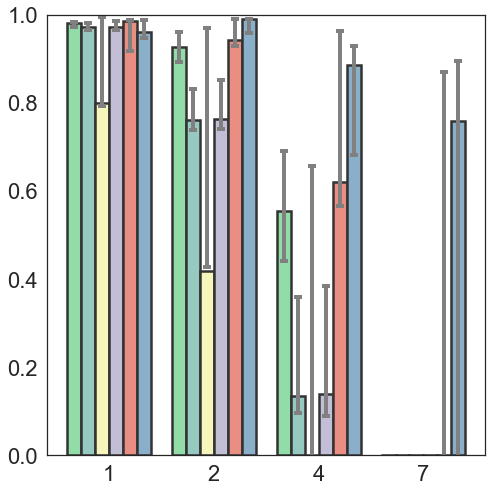

In [111]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.barplot(x="Delay",y="Prediction_MLE",hue="ModelName",
            edgecolor=".2",linewidth=2.5,
            palette=[(133./255, 234./255, 161./255)] + sns.color_palette("Set3")[:5],
            data=benchmarkingResultsDf,ax=ax)
# Plot error bars using the CI estimates obtained from bootstrapping. As these are
# custom error bars and this is a nested plot, needed to write some of my own code to
# get those error bars put into the right place
# Get x-position of bars
n_categories = len(benchmarkingResultsDf['ModelName'].unique())
bar_width = 0.8/n_categories # 0.8 is the default width value according to the docs
errBarDf = benchmarkingResultsDf.copy()
for i,delay in enumerate(benchmarkingResultsDf['Delay'].unique()):
    # for each delay value, get the positions of the mid-points of the bars
    barPosList = [i+x*bar_width+bar_width/2 for x in np.arange(-n_categories/2,n_categories/2)]
    errBarDf.loc[errBarDf.Delay==delay,'Delay'] = barPosList

ax.errorbar(x=errBarDf['Delay'], 
            y=errBarDf['Prediction_MLE'],
            yerr=np.array([errBarDf['Prediction_MLE']-errBarDf['Lower_Bound'],
                           errBarDf['Upper_Bound']-errBarDf['Prediction_MLE']]), 
            fmt='none', c='grey', capsize=4, elinewidth=4, capthick=4)

# Decorate plot
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(0,1)
plt.legend().remove()
plt.tight_layout()
plt.savefig("./figures/treatmentModelComparison_prediction_%s.pdf"%cellLine)

### d) Plot model parameters

In [28]:
modelsToPlotList = ["multiStep_equalParams", "multiStep_2phase", "singleStep_extraDivs"]

In [30]:
# Assemble parameter estimates and confidence intervals
tmpList = []
for modelName in modelsToPlotList:
    n_steps = modelComparisonDf.loc[modelComparisonDf['ModelName']==modelName,'n_steps'].values[0]
    # For the single compartment model (Model 3) there is only a single fit, so use that. For the
    # multi-compartment models choose the best one among the different n_step values.
    if modelName=="singleStep" or modelName=="singleStep_extraDivs":
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "CycleArrestModel_"+modelName)
    else:
        modelType = Lookup_modelType(modelName)
        if modelName!="multiStep_2phase":
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType+"_"+modelName.split("multiStep_")[-1], "n_steps_%d"%(n_steps))
        else:
            currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelType, "n_steps_%d"%(n_steps))
    
    # Compute confidence intervals
    bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
    fitObj,_ = LoadFit(Lookup_modelType(modelName),fitDir=currOutDir)
    tmpDf = compute_confidenceInterval_parameters(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx 
                                                  alpha=ci_significanceLevel)
    tmpDf['Model'] = modelName
    tmpDf['CellLine'] = cellLine
    tmpList.append(tmpDf)
paramsDf = pd.concat(tmpList)

  Parameter  Estimate_MLE   Lower_Bound  Upper_Bound                  Model  \
2     alpha      0.692812  6.631900e-01     0.868138  multiStep_equalParams   
1      beta      0.025408  5.482062e-16     0.123998  multiStep_equalParams   
0       d_A      2.298504  1.161821e-01     4.000000  multiStep_equalParams   
0       xxx   -100.000000 -1.000000e+02  -100.000000                   -100   

  CellLine  
2   OVCAR4  
1   OVCAR4  
0   OVCAR4  
0     -100  
  Parameter  Estimate_MLE   Lower_Bound  Upper_Bound             Model  \
3     alpha  5.704553e-01  5.380330e-01     1.000000  multiStep_2phase   
1      beta  2.427874e-11  2.258002e-20     0.268328  multiStep_2phase   
0       d_A  3.365570e-01  4.141886e-02     3.999940  multiStep_2phase   
2     gamma  4.000000e+00  5.452245e-01     4.000000  multiStep_2phase   

  CellLine  
3   OVCAR4  
1   OVCAR4  
0   OVCAR4  
2   OVCAR4  
  Parameter  Estimate_MLE  Lower_Bound  Upper_Bound                 Model  \
1     alpha      0.941328 

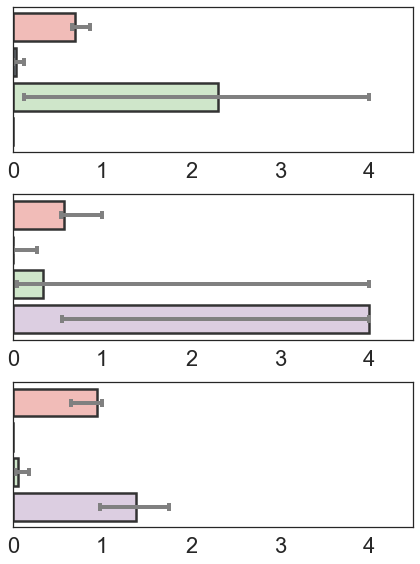

In [34]:
fig, axList = plt.subplots(3,1,figsize=(6,8))
for i,modelName in enumerate(modelsToPlotList):
    ax = axList[i]
    currDataDf = paramsDf[paramsDf.Model==modelName]
    # Add a "phantom" entry for Model 2 in order to get parameters in all models to align
    if modelName!="multiStep_2phase":
        phantomRow = currDataDf.iloc[:1].copy()
        phantomRow.loc[:] = -100
        phantomRow['Parameter'] = "xxx"
        currDataDf = pd.concat([currDataDf,phantomRow])    
    # Sort parameters for all models in the same order
    if modelName=="multiStep_equalParams": plottingOrder = {"alpha":0, "beta":1, "d_A":2}
    if modelName=="multiStep_2phase": plottingOrder = {"alpha":0, "beta":1, "d_A":2}
    if modelName=="singleStep_extraDivs": plottingOrder = {"alpha":0, "xxx":1, "d_A":2}
    currDataDf = currDataDf.sort_values(by=['Parameter'], key=lambda x: x.map(plottingOrder))
    print(currDataDf)
    sns.barplot(x="Estimate_MLE",y="Parameter",
                edgecolor=".2",linewidth=2.5,
                palette="Pastel1",
                data=currDataDf,ax=ax)
    # Extract and plot error bars
    ax.errorbar(x=currDataDf["Estimate_MLE"], 
                y=np.arange(currDataDf.shape[0]),
                xerr=np.array([currDataDf['Estimate_MLE']-currDataDf['Lower_Bound'],
                               currDataDf['Upper_Bound']-currDataDf['Estimate_MLE']]), 
                fmt='none', c='grey', capsize=4, elinewidth=4, capthick=4)
    # Decorate plot
    ax.set_xlim(0,4.5)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_yticks([])
plt.tight_layout()
plt.savefig("./figures/params_treatmentModel_%s.pdf"%cellLine)

In [33]:
paramsDf[np.isin(paramsDf,modelsToPlotList)]

,Parameter,Estimate_MLE,Lower_Bound,Upper_Bound,Model,CellLine
0,d_A,2.298504e+00,1.161821e-01,4.000000,multiStep_equalParams,OVCAR4
1,beta,2.540794e-02,5.482062e-16,0.123998,multiStep_equalParams,OVCAR4
2,alpha,6.928125e-01,6.631900e-01,0.868138,multiStep_equalParams,OVCAR4
0,d_A,3.365570e-01,4.141886e-02,3.999940,multiStep_2phase,OVCAR4
1,beta,2.427874e-11,2.258002e-20,0.268328,multiStep_2phase,OVCAR4
2,gamma,4.000000e+00,5.452245e-01,4.000000,multiStep_2phase,OVCAR4
3,alpha,5.704553e-01,5.380330e-01,1.000000,multiStep_2phase,OVCAR4
0,d_A,5.138117e-02,2.427652e-02,0.171343,singleStep_extraDivs,OVCAR4
1,alpha,9.413277e-01,6.470045e-01,1.000000,singleStep_extraDivs,OVCAR4
2,phi,1.376544e+00,9.723516e-01,1.754531,singleStep_extraDivs,OVCAR4
